In [1]:
%%time
from collections import Counter
import time
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import gc
import time
import optuna
import sys
import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


CPU times: user 1.05 s, sys: 97.9 ms, total: 1.15 s
Wall time: 1.15 s


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


# var_0, var_1, ...
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

display(train_df.head())

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [12]:
standradize = True

if standradize:
    print('Standradizing the data..')
    #inf values can result from squaring
    scaler = StandardScaler()
    train_df.iloc[:,2:] = scaler.fit_transform(train_df.iloc[:,2:])
    test_df.iloc[:,1:] = scaler.fit_transform(test_df.iloc[:,1:])
    print('Data Standradized!')

Standradizing the data..
Data Standradized!


### Check duplicated data

In [3]:
def get_unique_feature(df, train=False):
    
    df_copy = df.copy()
#     if not train:
#         df_copy.drop(['ID_code'], axis=1, inplace=True)
#     elif train:
#         print("train")
#         df_copy.drop(['ID_code', "target"], axis=1, inplace=True)
            
    df_test = df_copy.values

    unique_samples = []
    unique_count = np.zeros_like(df_test)
    for feature in tqdm(range(df_test.shape[1])):
        _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
        unique_count[index_[count_ == 1], feature] += 1

    # Samples which have unique values are real the others are fake
    real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
    synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

    print("real:", len(real_samples_indexes))
    print("syn:", len(synthetic_samples_indexes))

    feature_unique = np.sum(unique_count, axis=0) / len(df_test)

    return feature_unique

In [4]:
# train1_feature_unique = get_unique_feature(train_df.query("target==1"), train=True)
# # test_feature_unique = get_unique_feature(test_df, train=False)
# train0_feature_unique = get_unique_feature(train_df.query("target==0"), train=True)
# train_feature_unique = get_unique_feature(train_df)
# test_feature_unique = get_unique_feature(test_df, train=False)

train_data = train_df[features]
test_data = test_df[features]

all_df = pd.concat([train_data, test_data])
all_feature_unique = get_unique_feature(all_df)


# fig = plt.figure(figsize=(20,10))
# plt.bar(features, train0_feature_unique, color="red", alpha=0.3, label="train:0")
# plt.bar(features, train1_feature_unique, color="blue", alpha=0.3, label="train:1")
# plt.bar(features, test_feature_unique, color="green", alpha=0.3, label="test")
# plt.bar(features, train_feature_unique, color="yellow", alpha=0.3, label="train_all")

# plt.ylabel("unique ratio", fontsize=30)
# plt.legend()
# plt.show()


real: 300000
syn: 100000


In [25]:
all_df.shape

(400000, 200)

In [5]:
cat_features_idx = np.argwhere(all_feature_unique < 0.05)[:, 0]
cat_features = []
for idx in cat_features_idx:
    cat_features.append("var_{}".format(idx))
    
print("No. highly duplicated featres : ", len(cat_features))

No. highly duplicated featres :  66


In [34]:
train_df.shape

(200000, 202)

In [6]:
agg_df_list = {}

for feature in tqdm(cat_features[:5]):
    agg_df = all_df.groupby(feature)
    agg_df_mean = agg_df.mean()
    agg_df_mean.columns = ["{}_by_{}".format(col, feature) for col in agg_df_mean.columns.values]
    agg_df_list[feature] = agg_df_mean
    print(feature)
    
for feature in tqdm(cat_features[:5]):
    all_df = all_df.merge(agg_df_list[feature], on=feature,how='left')
#     test_df = test_df.merge(agg_df_list[feature], on=feature,how='left')

len_train = len(train_df)
train_df = all_df[:len_train]
test_df  = all_df[len_train:]

var_3
var_4
var_6
var_9
var_12



In [7]:
train_df.shape

(200000, 1195)

### check out the categorical features

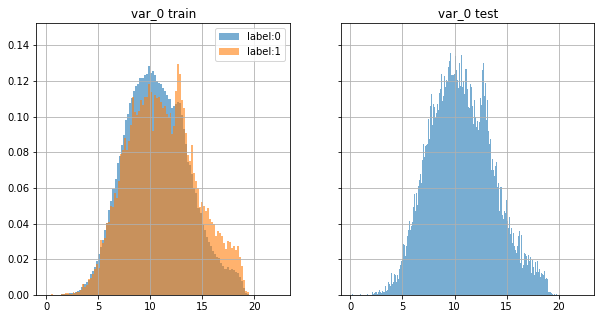

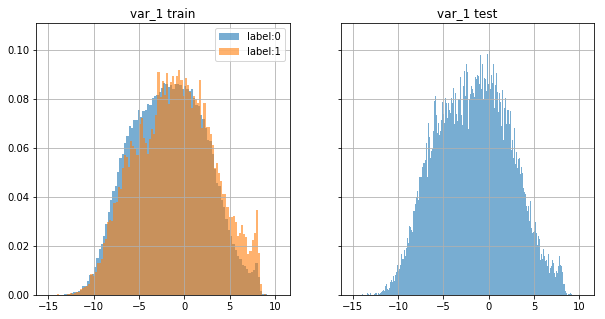

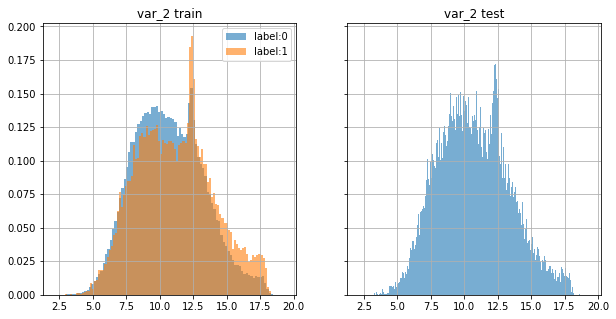

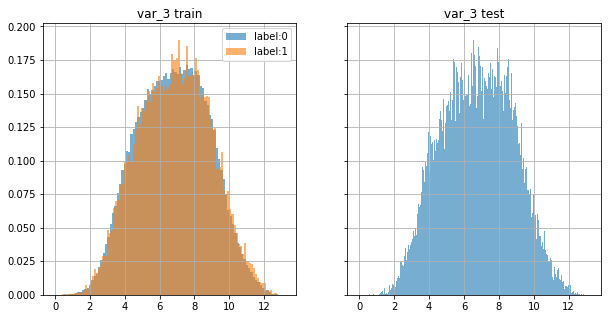

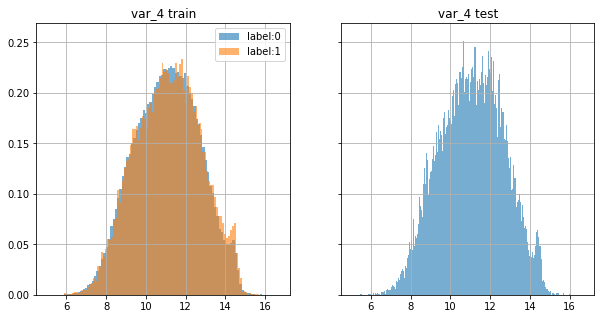

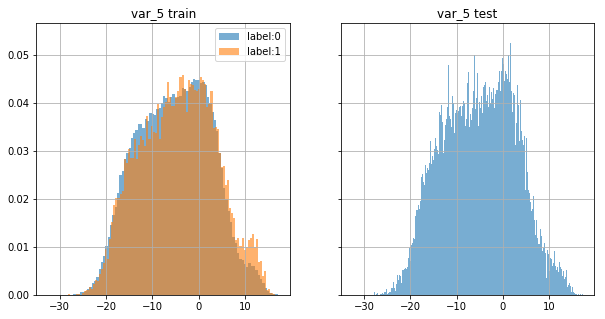

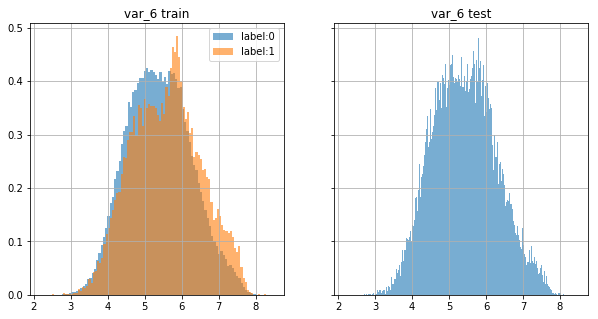

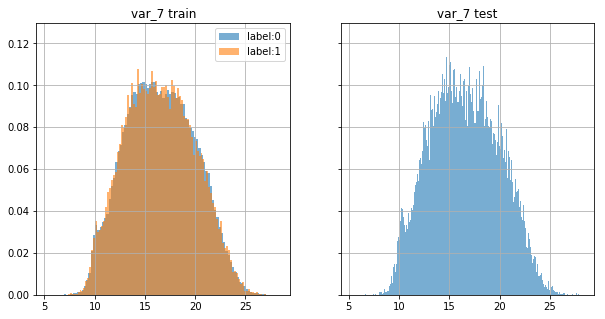

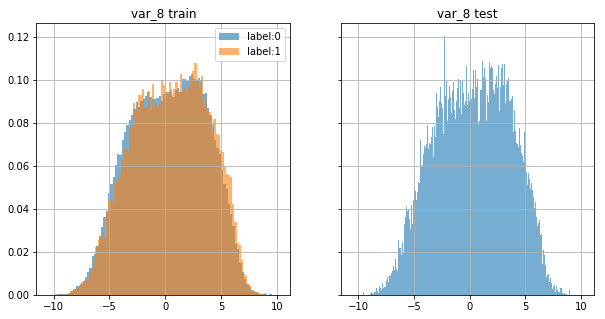

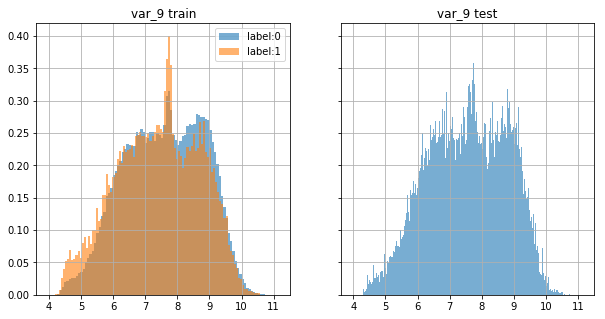

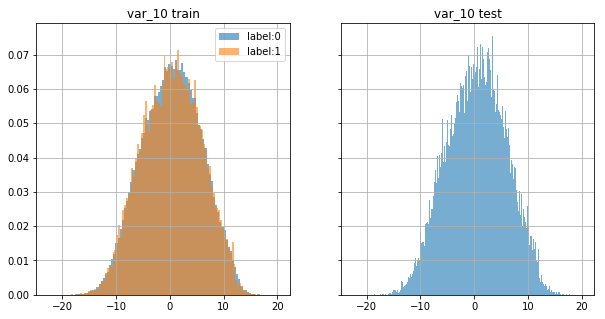

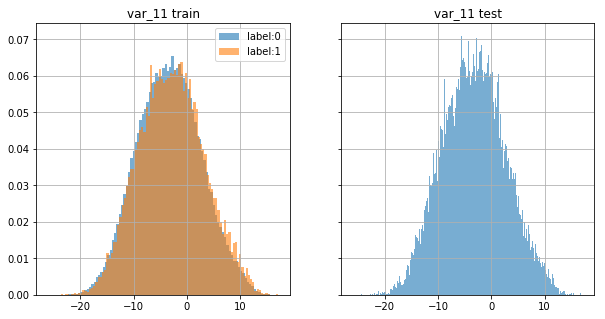

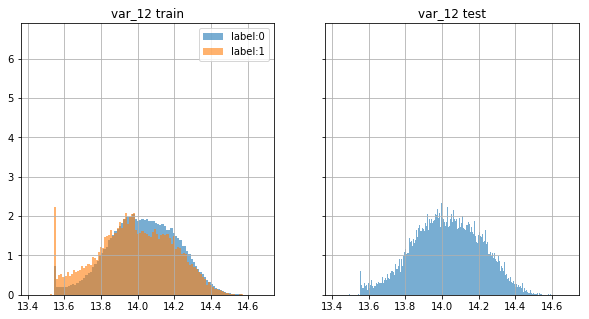

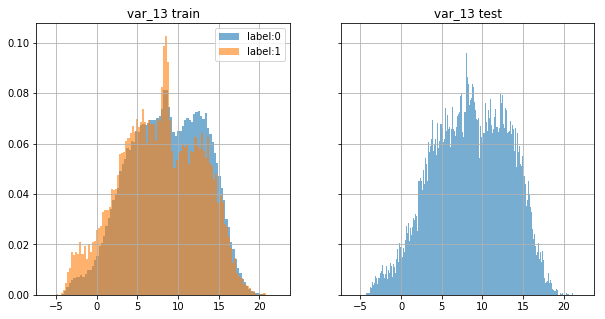

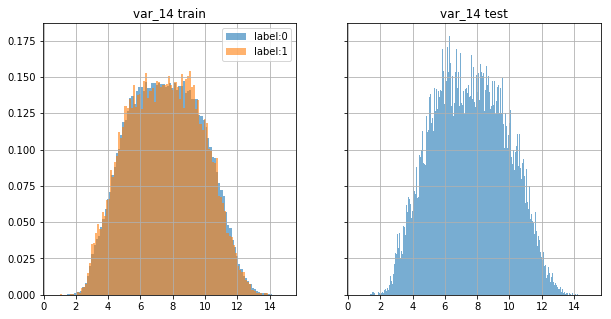

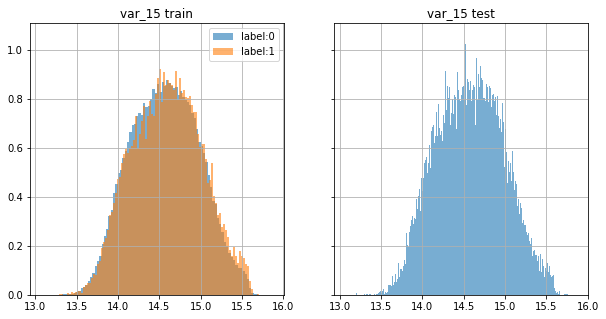

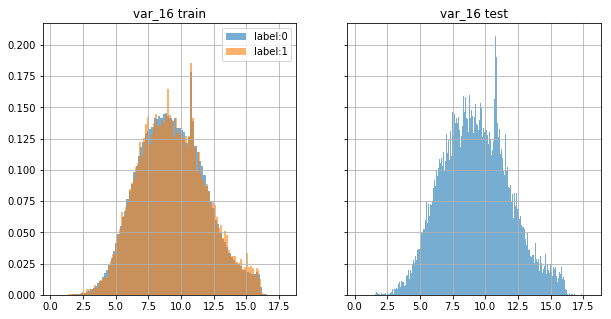

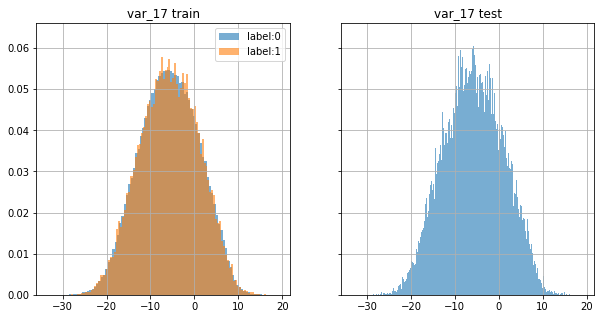

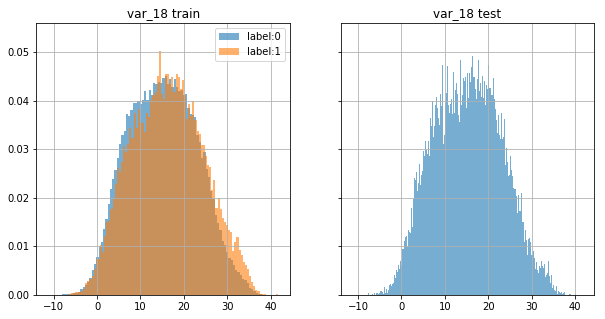

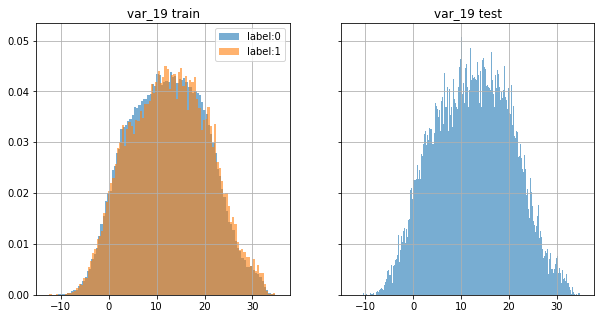

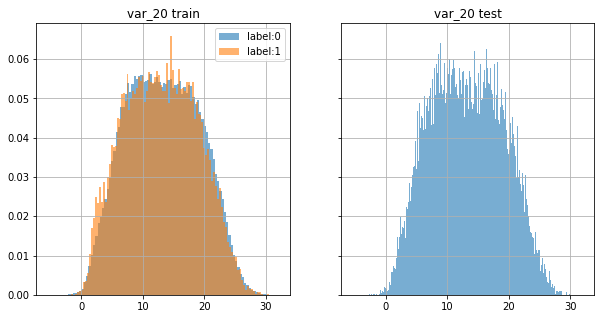

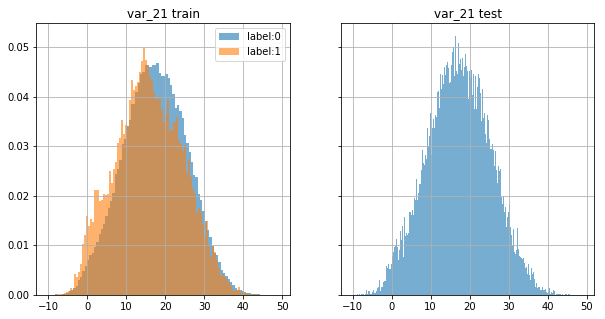

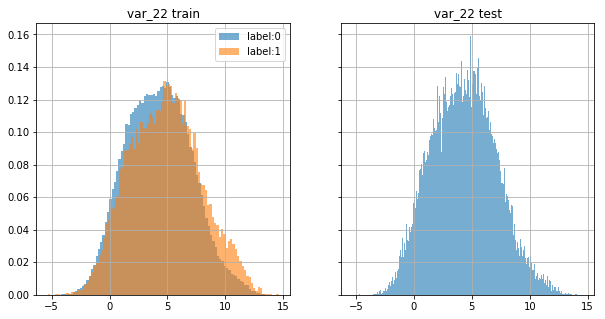

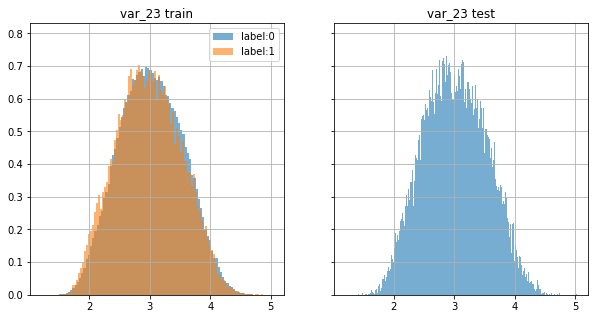

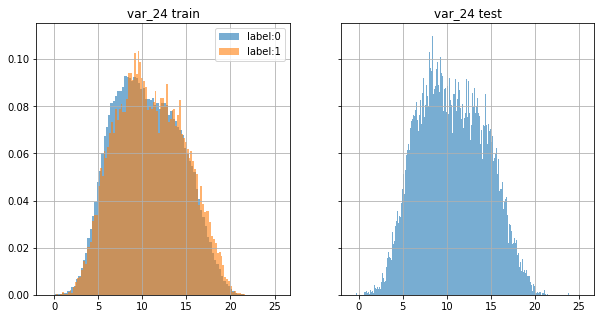

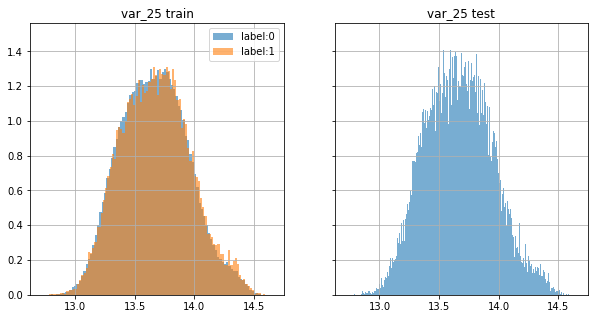

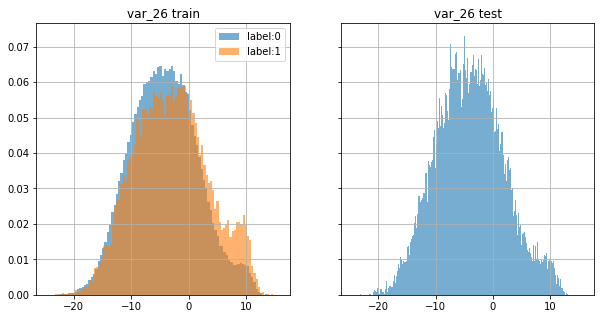

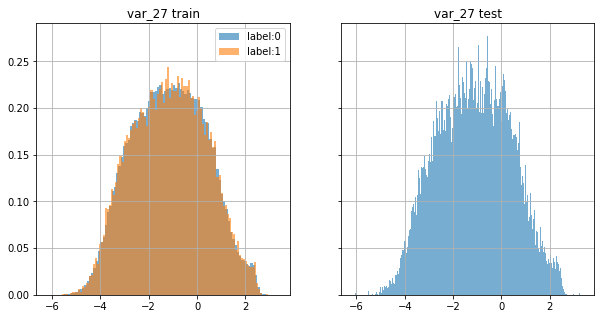

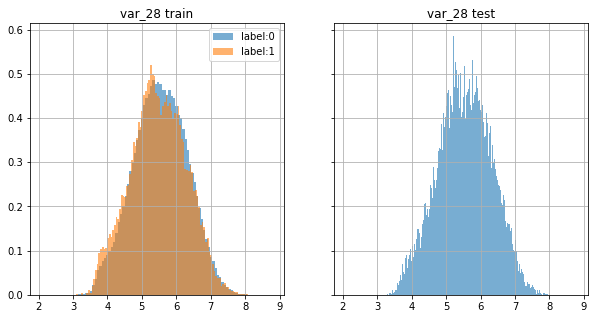

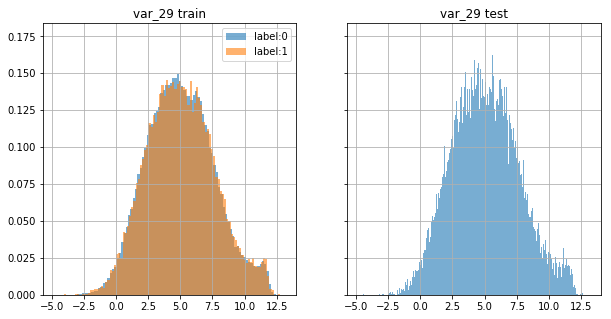

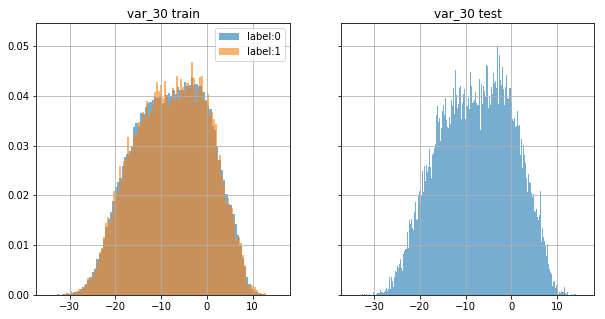

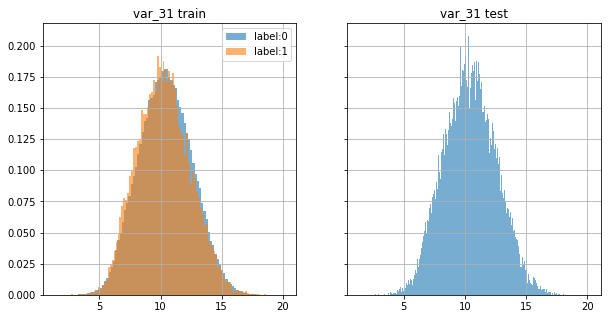

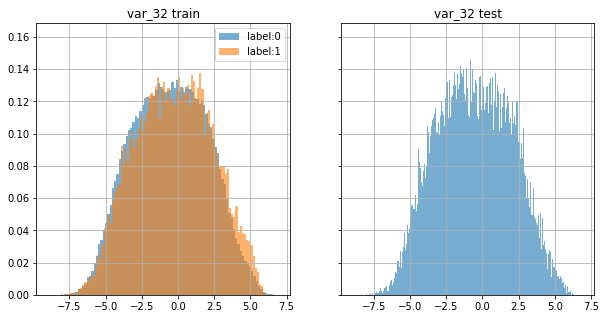

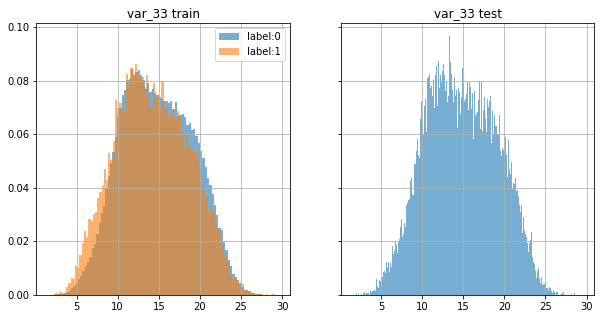

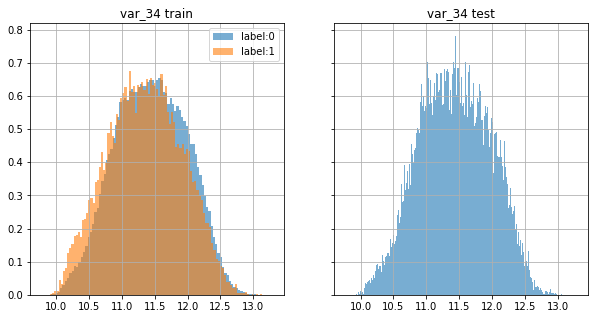

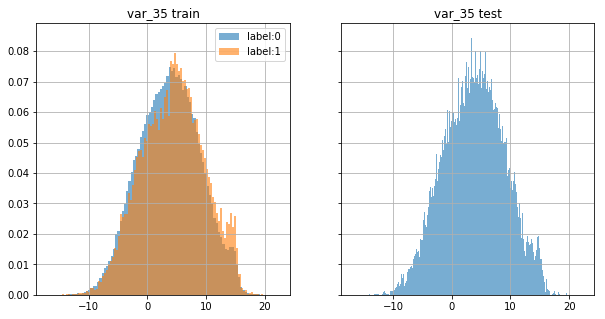

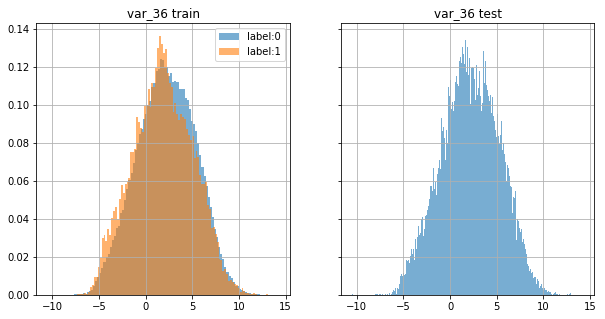

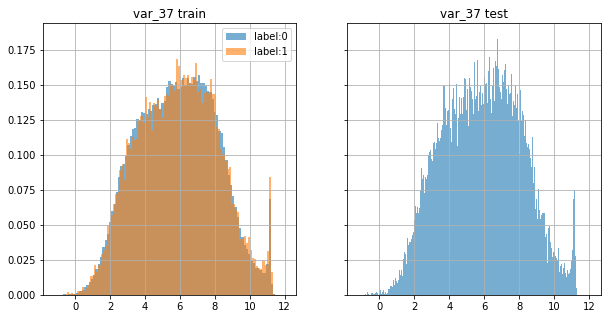

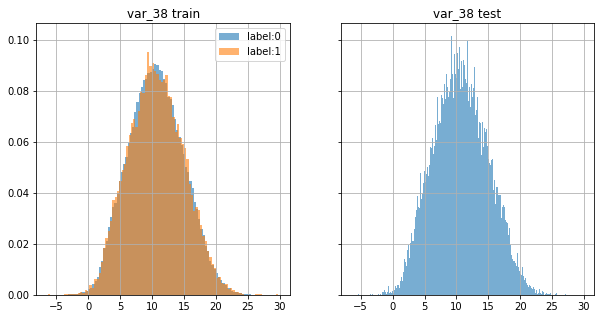

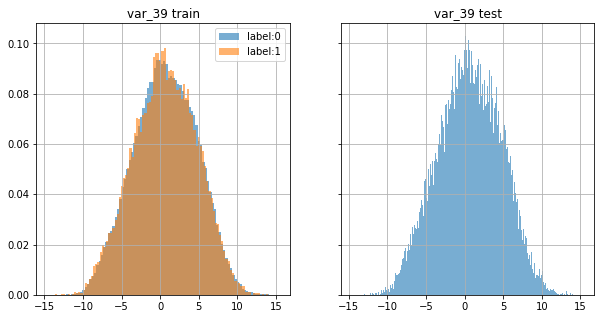

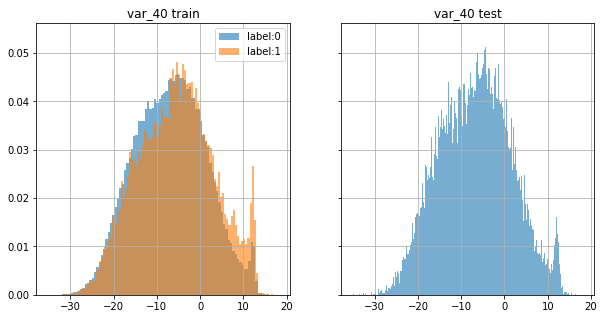

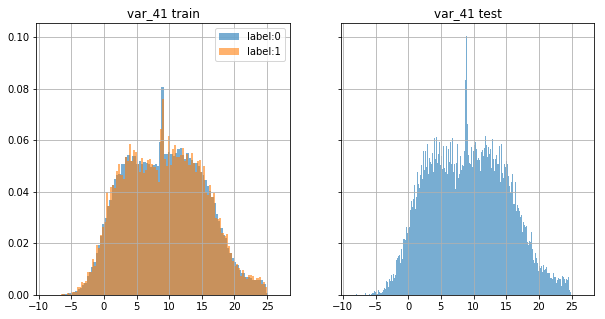

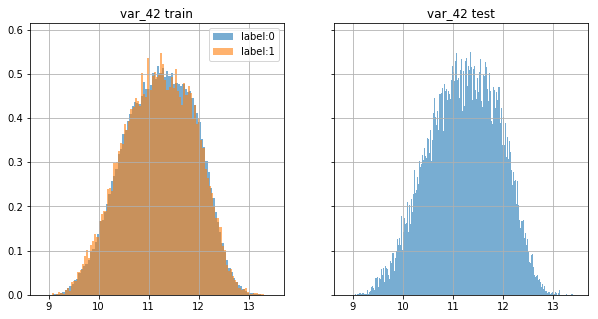

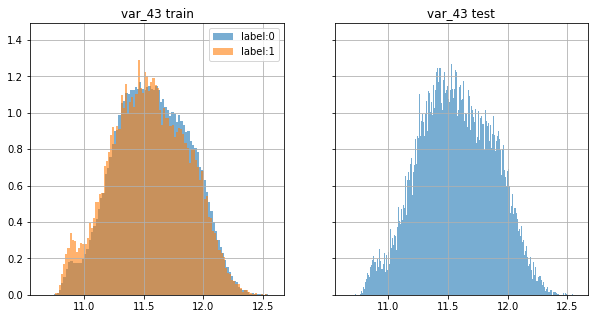

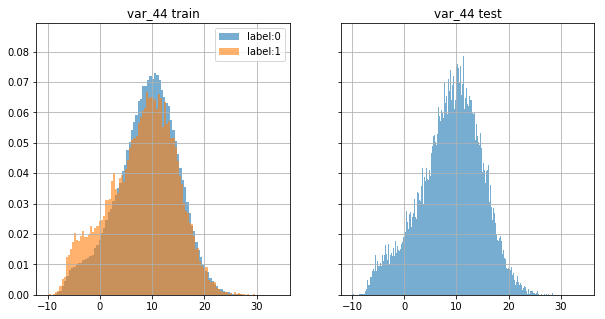

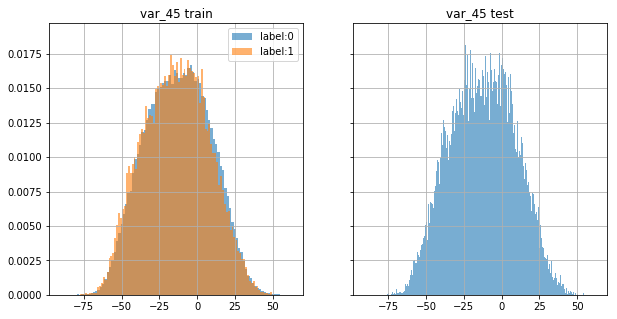

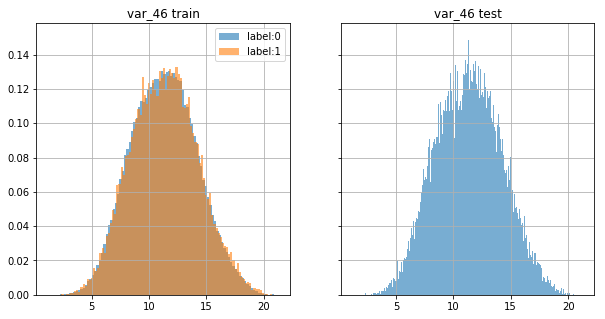

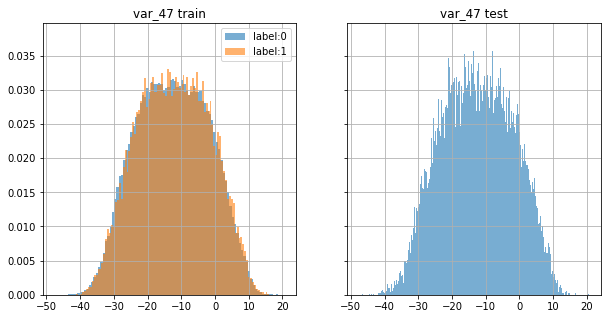

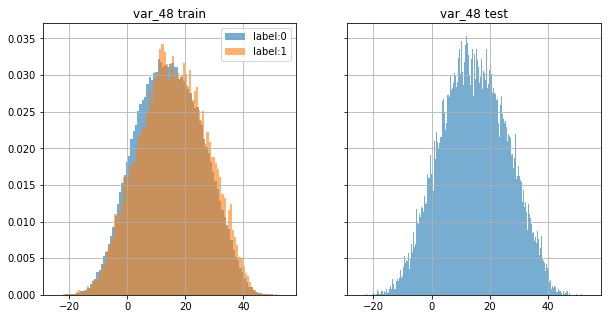

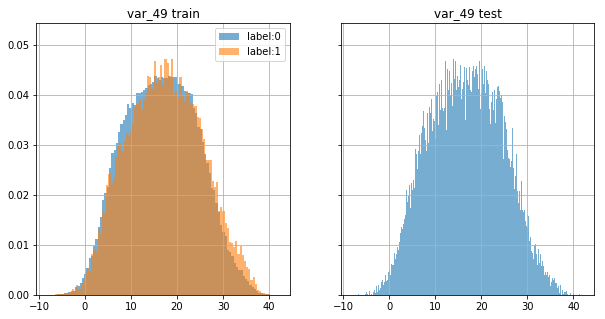

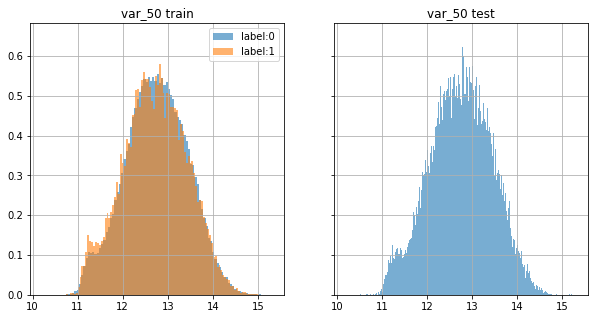

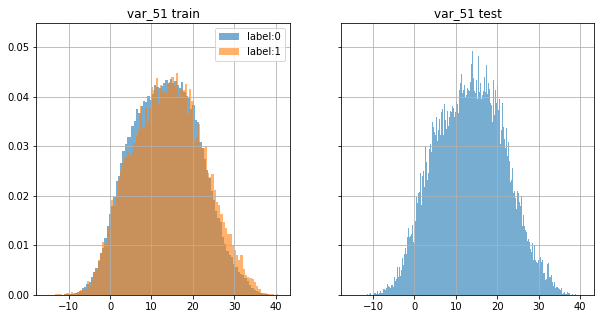

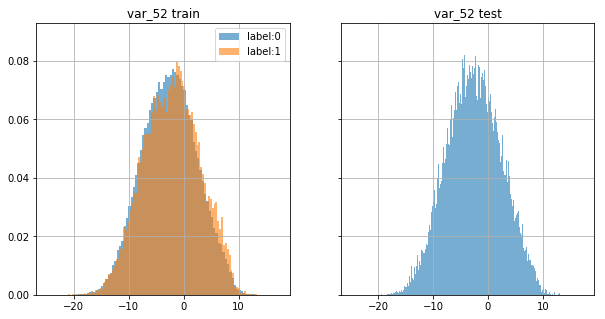

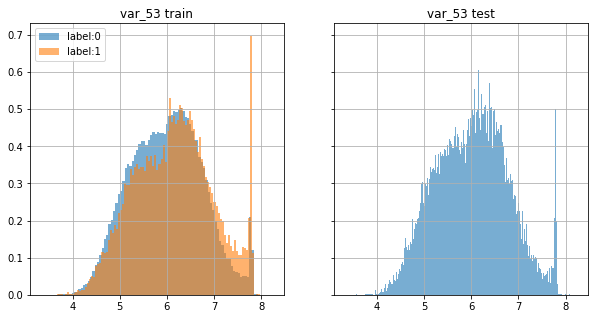

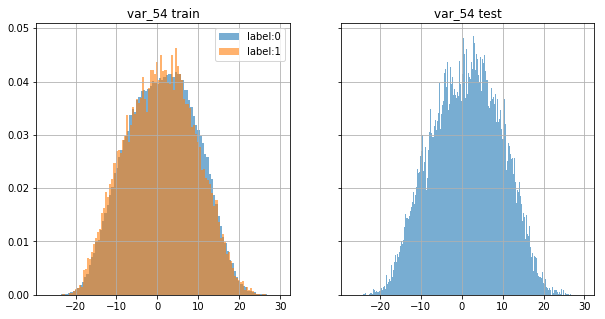

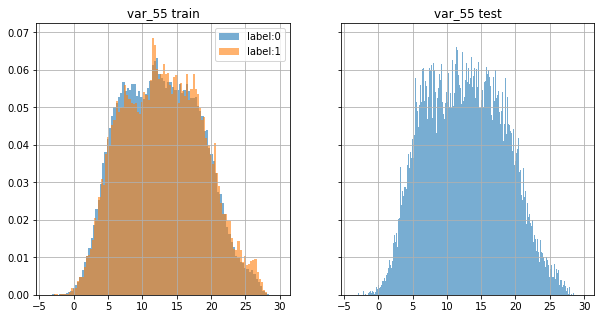

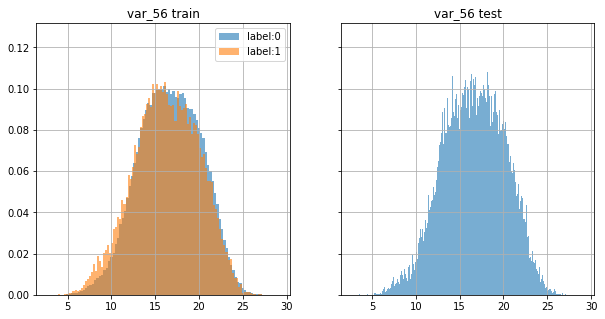

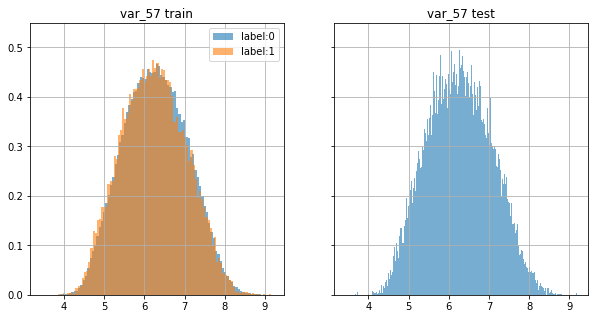

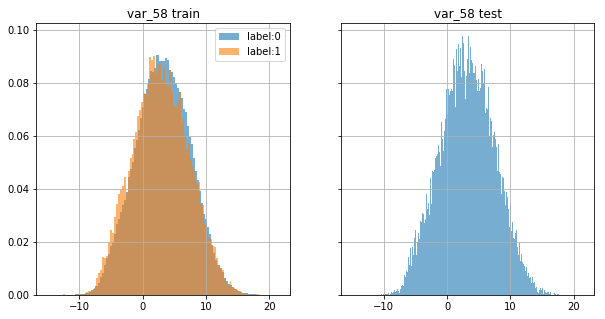

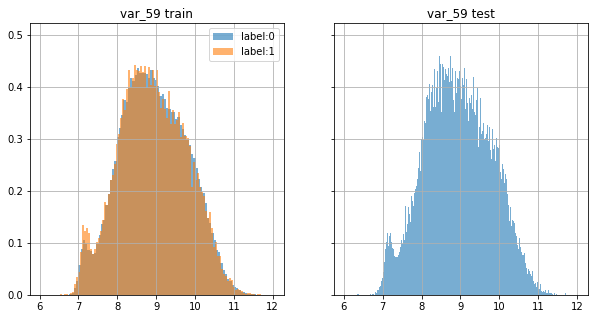

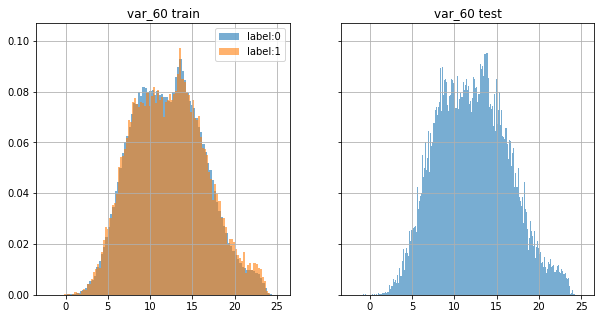

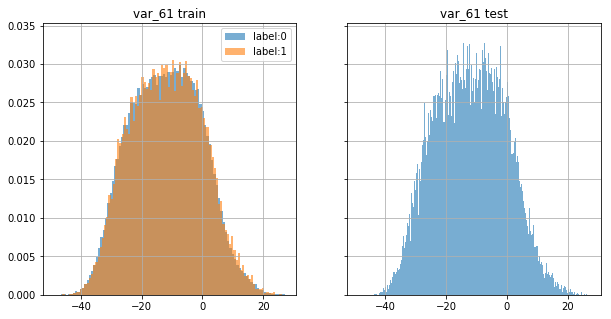

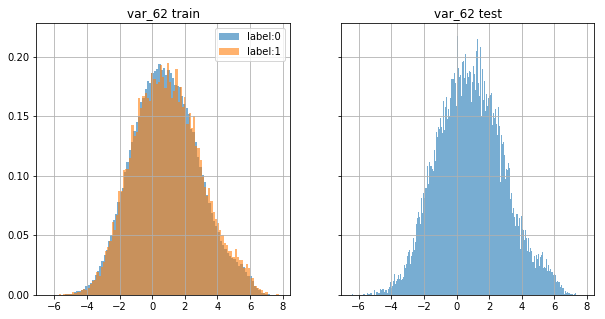

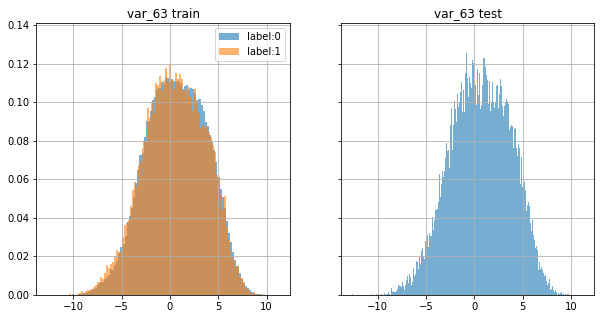

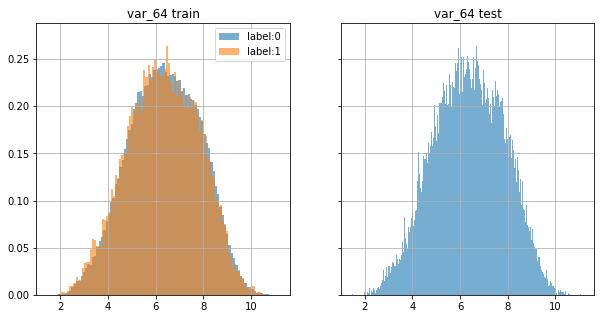

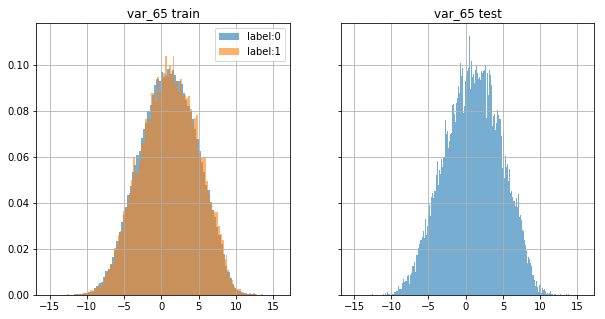

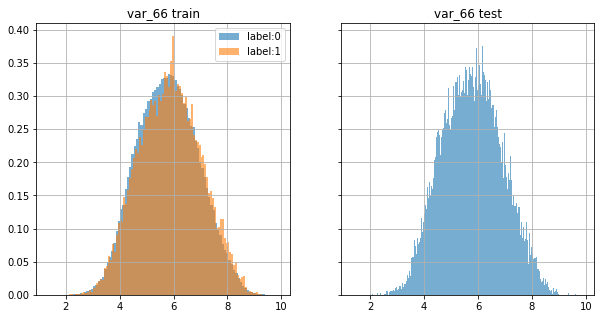

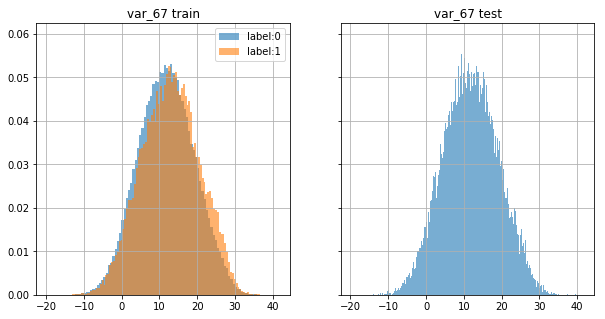

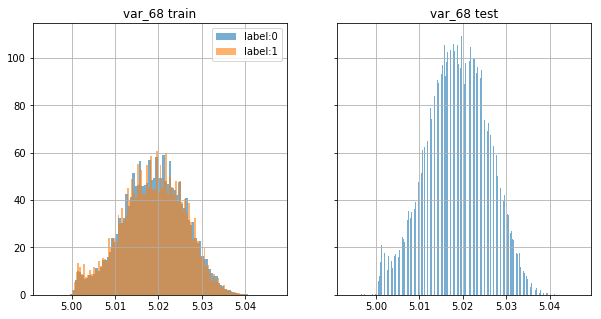

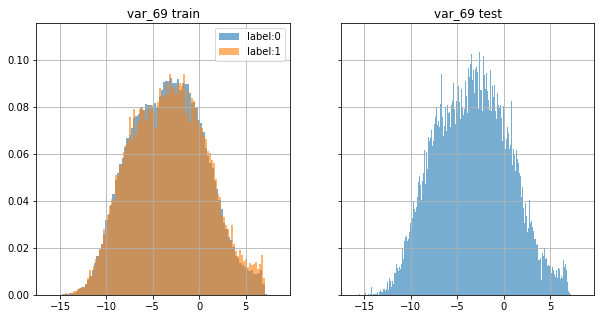

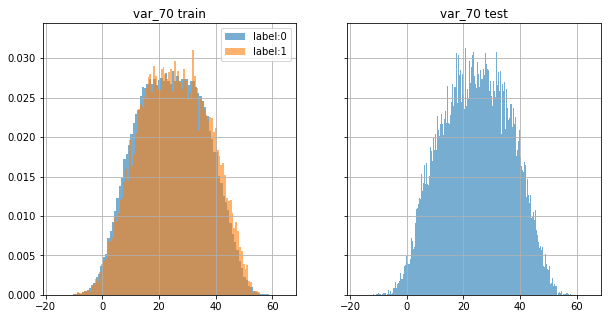

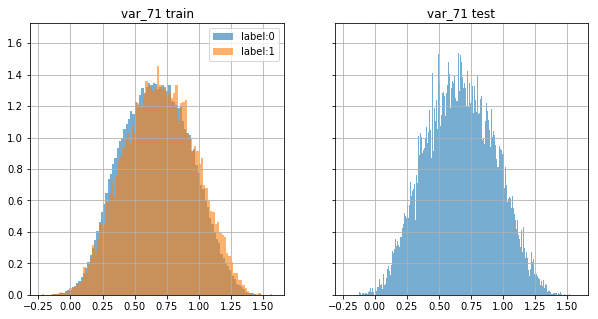

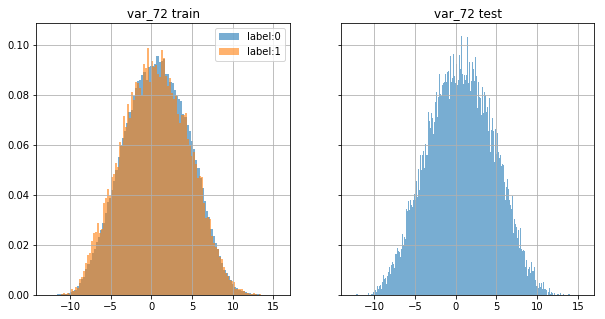

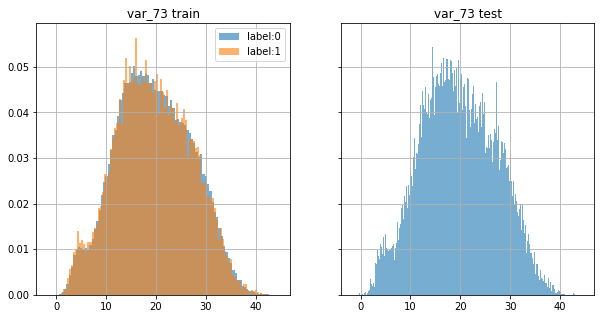

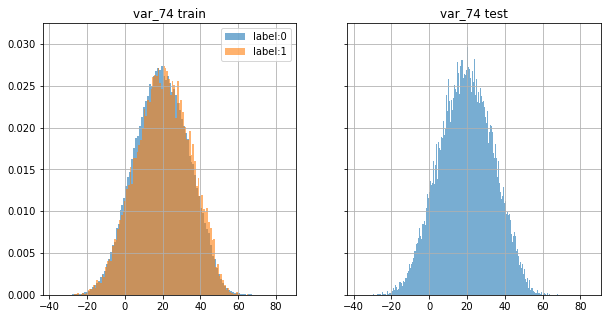

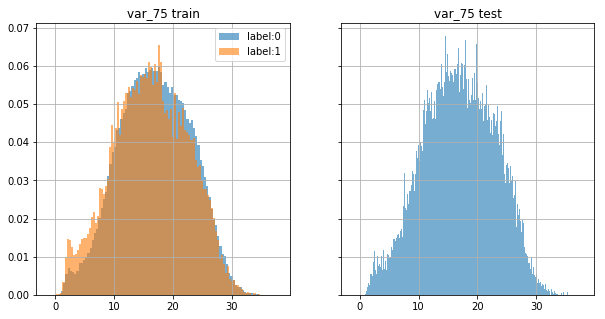

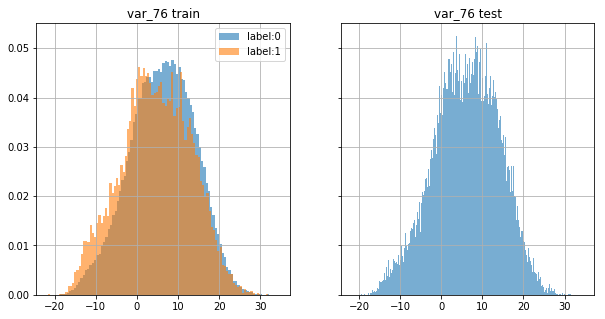

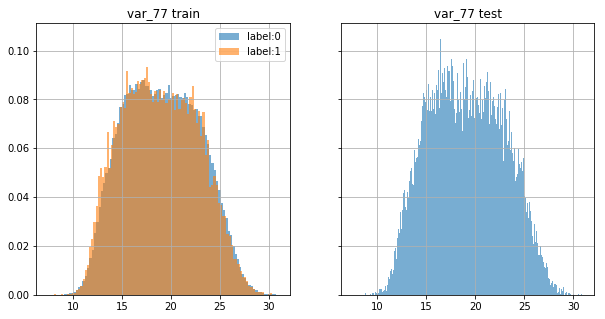

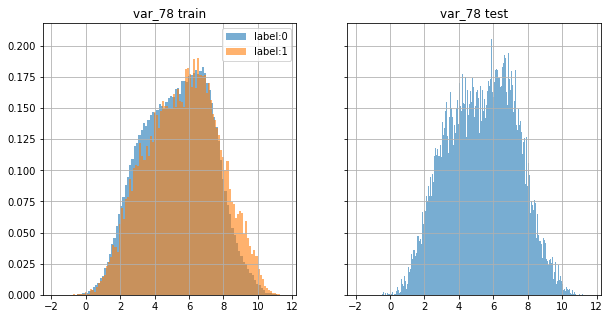

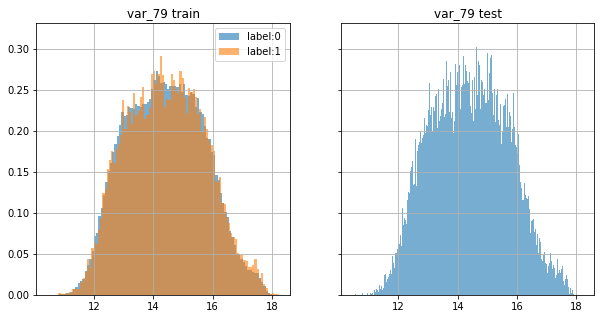

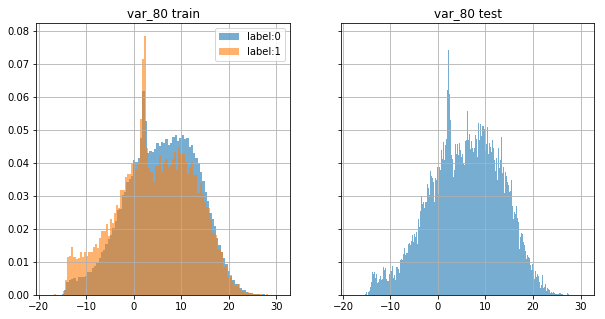

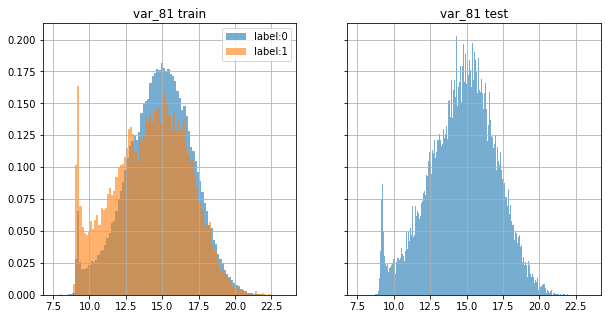

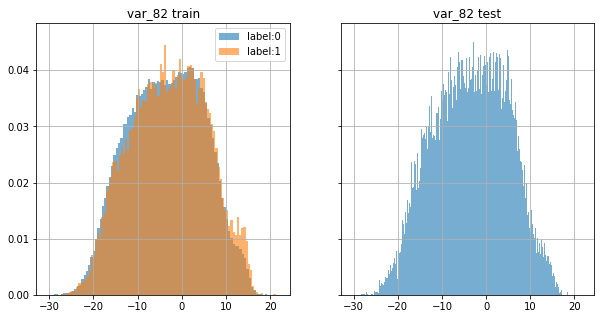

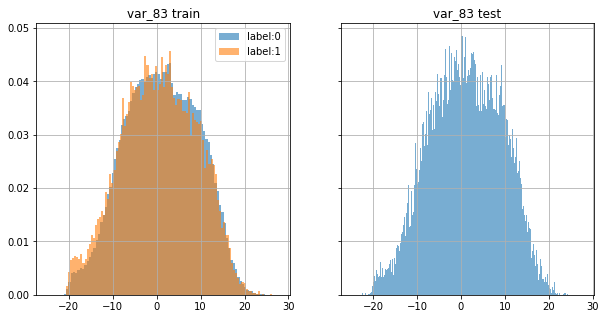

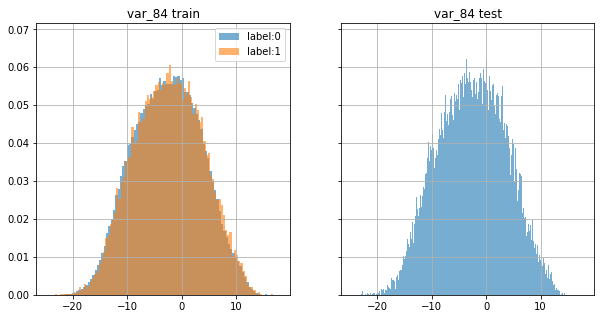

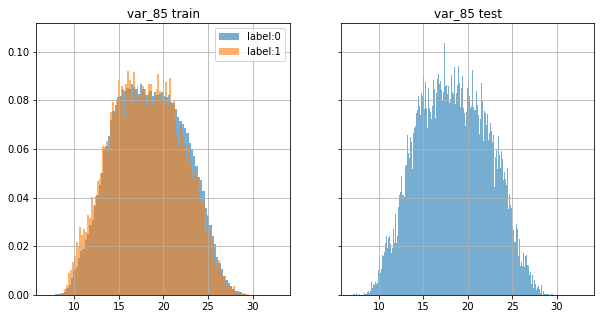

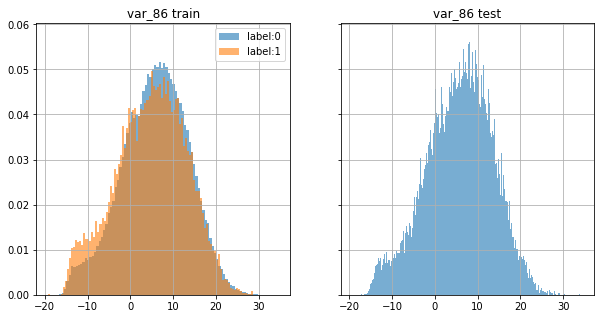

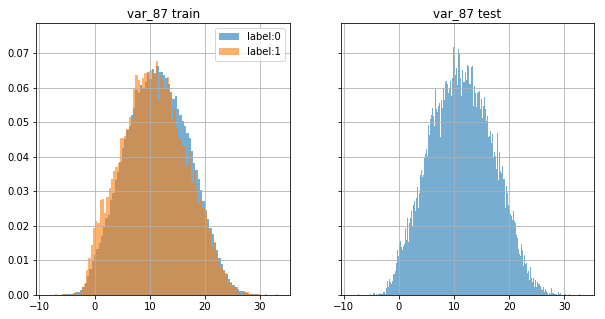

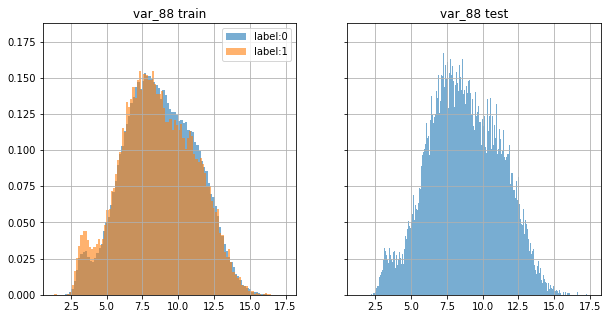

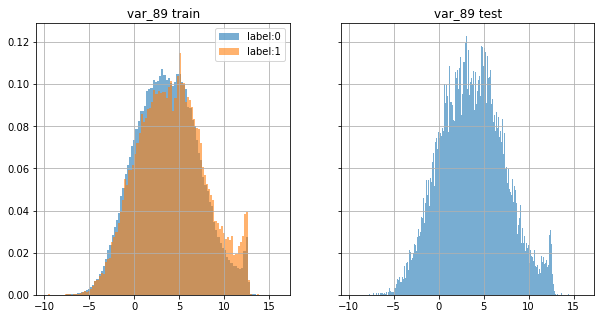

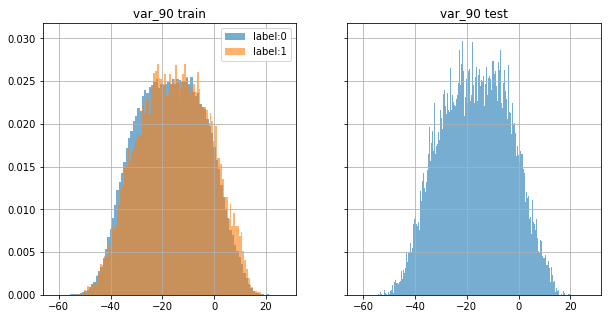

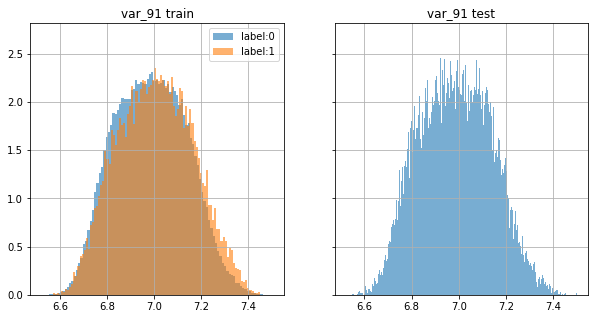

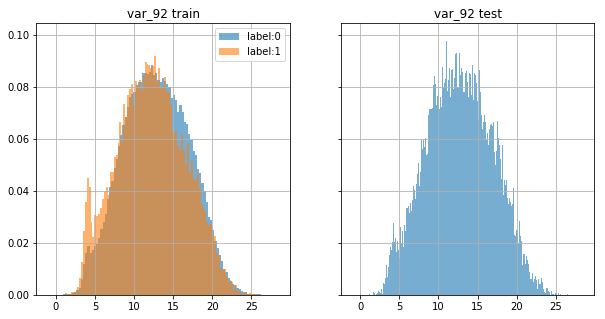

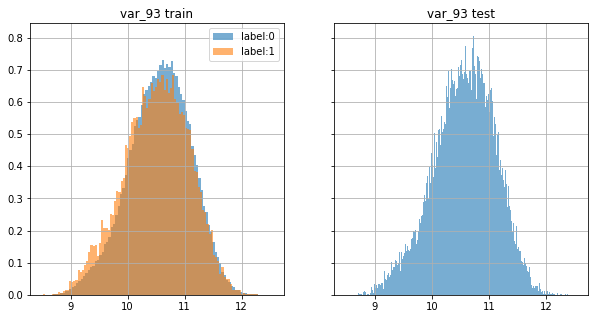

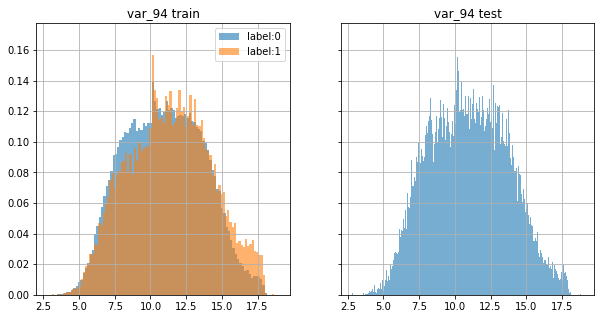

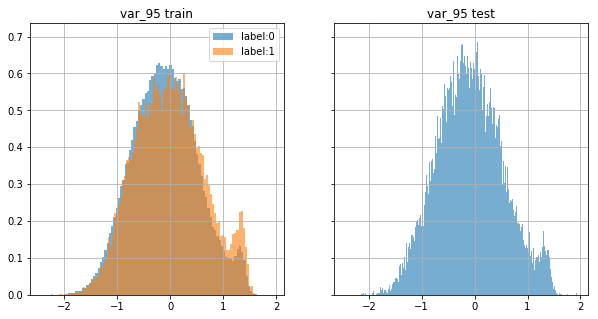

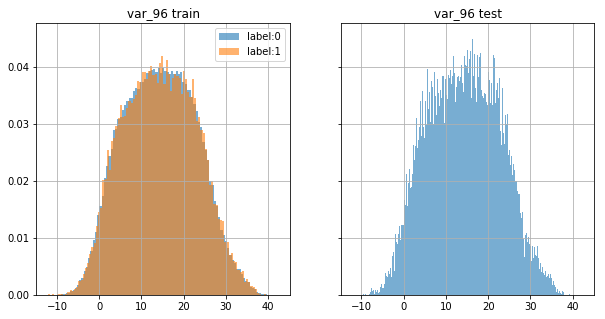

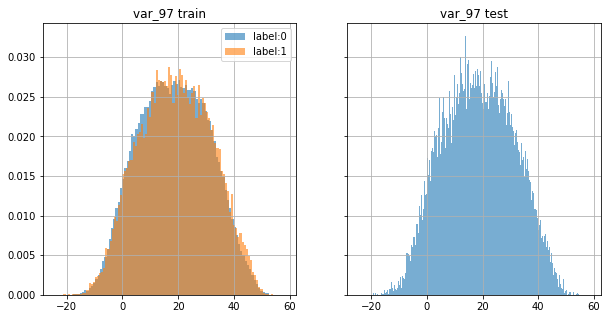

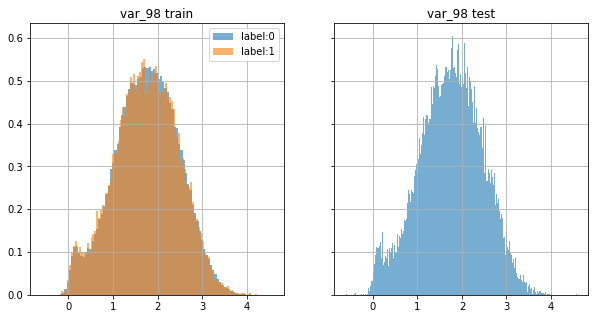

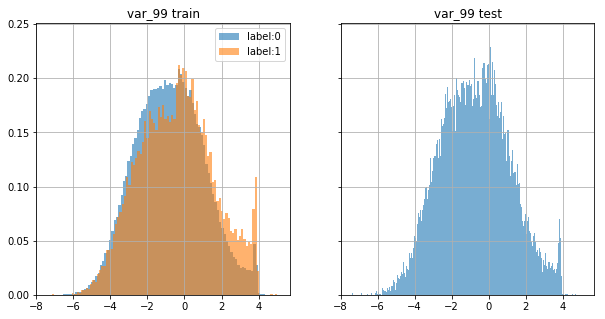

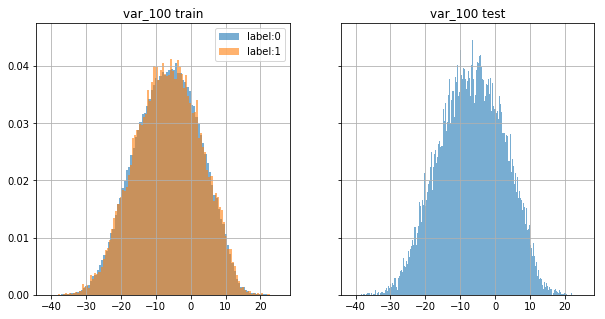

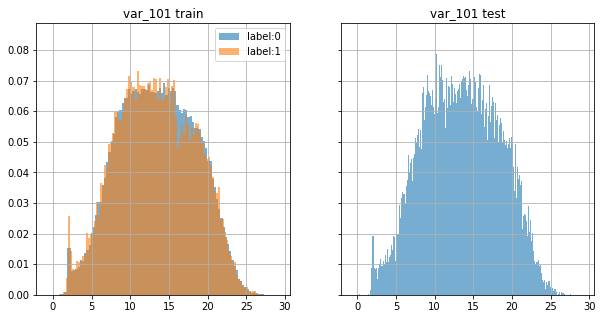

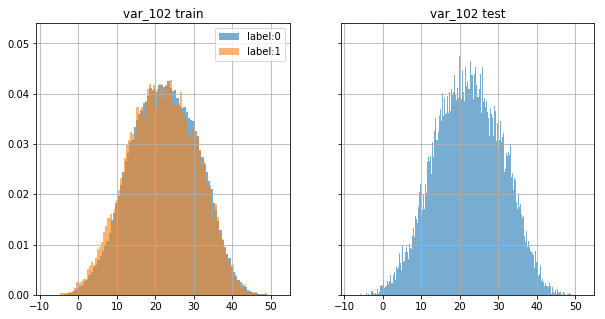

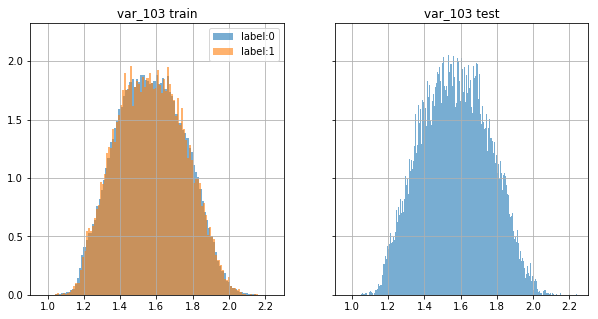

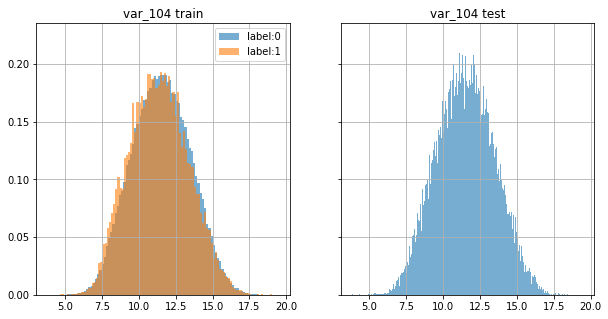

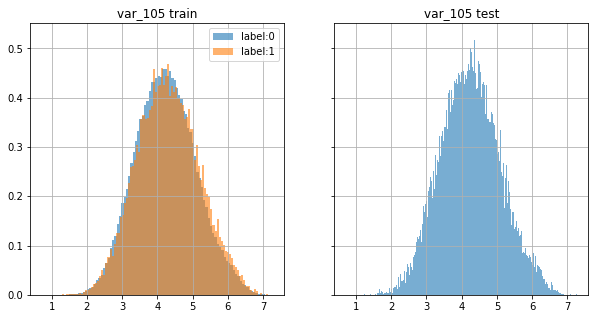

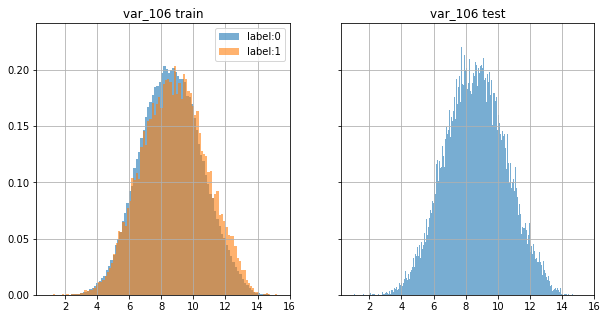

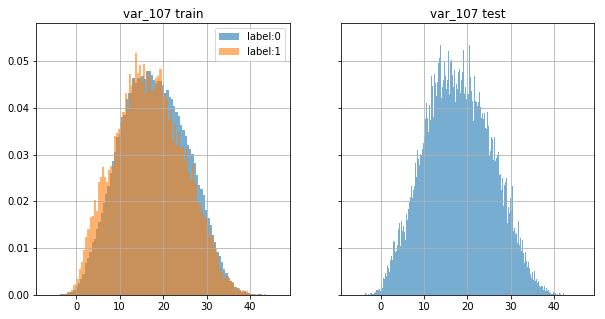

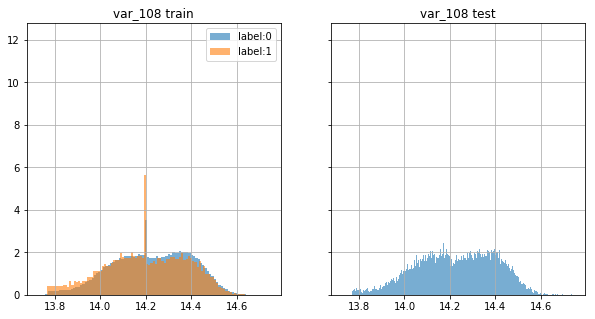

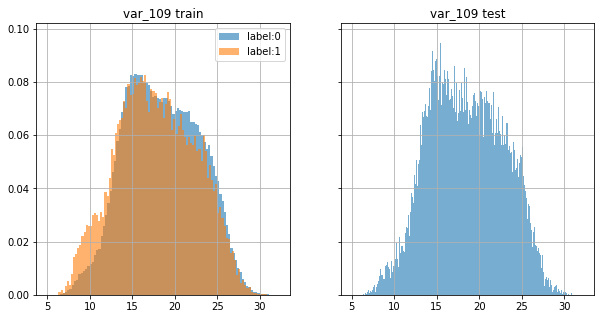

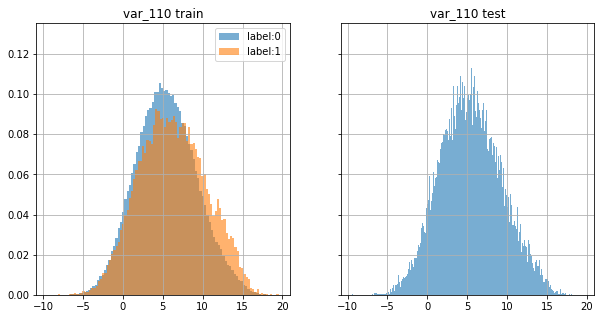

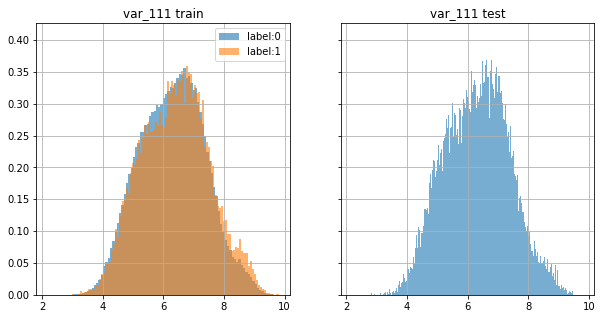

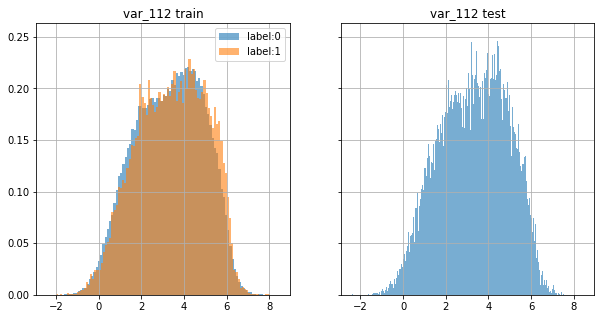

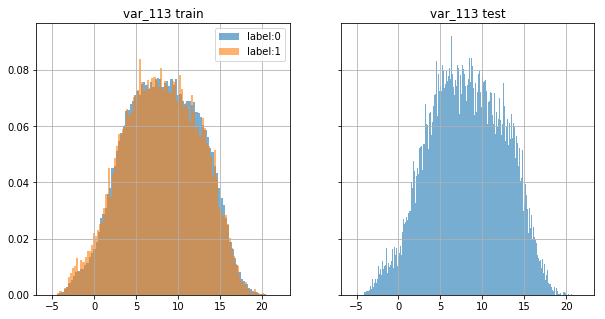

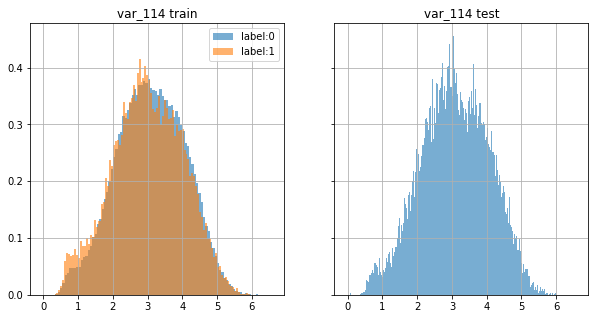

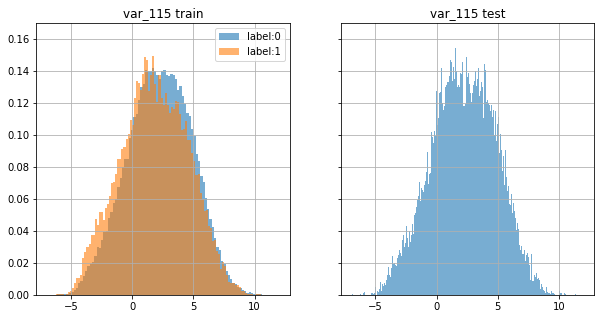

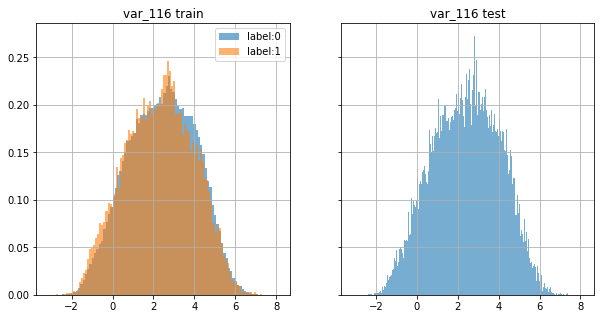

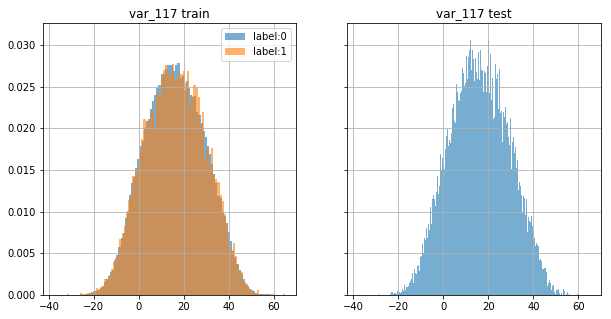

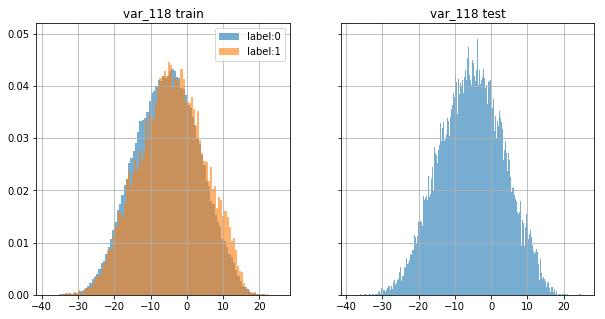

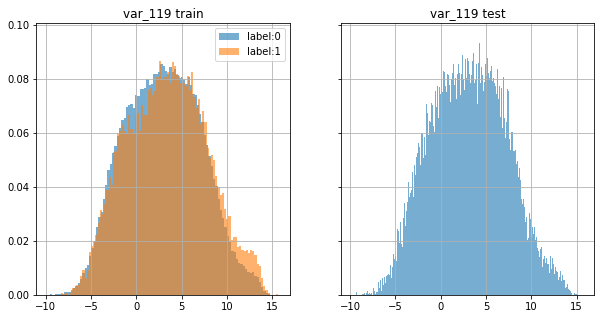

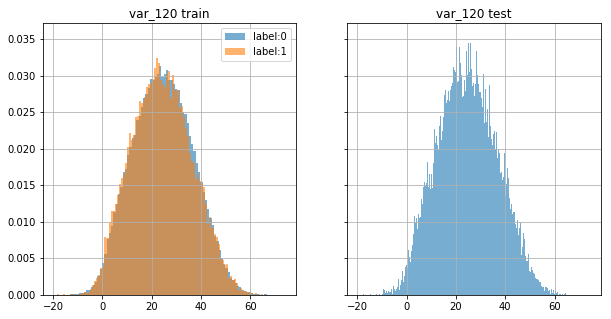

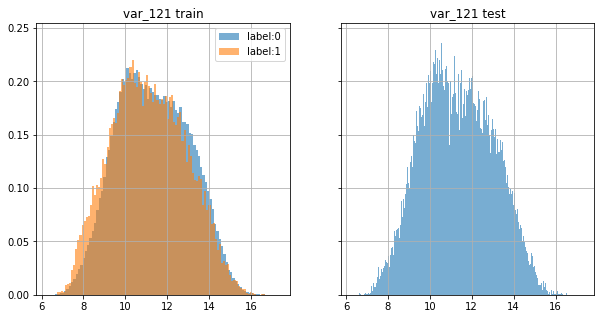

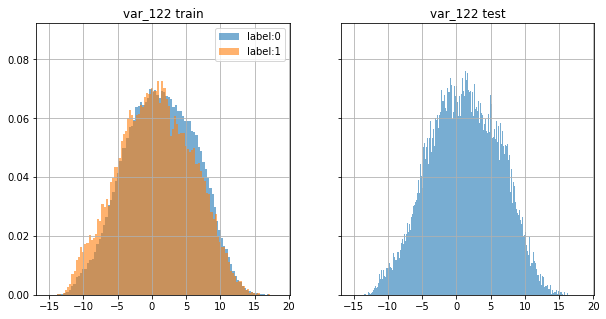

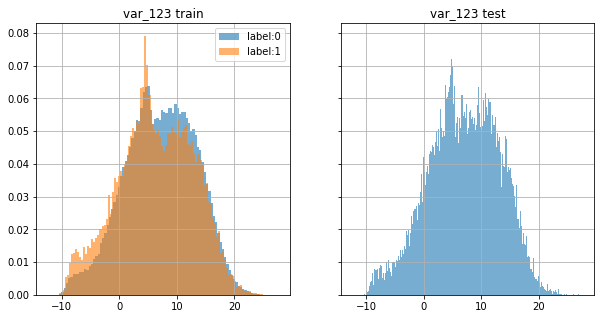

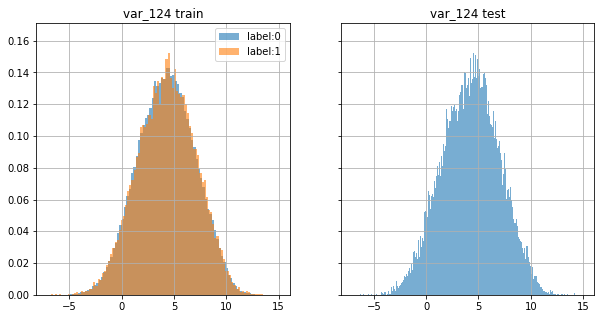

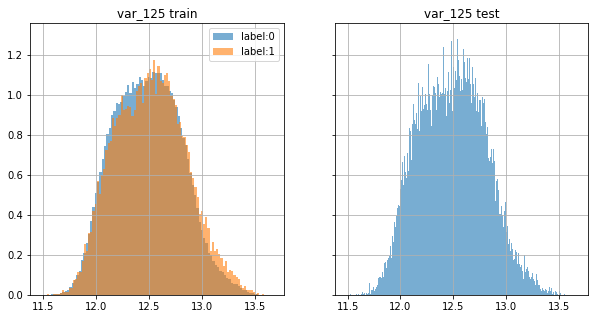

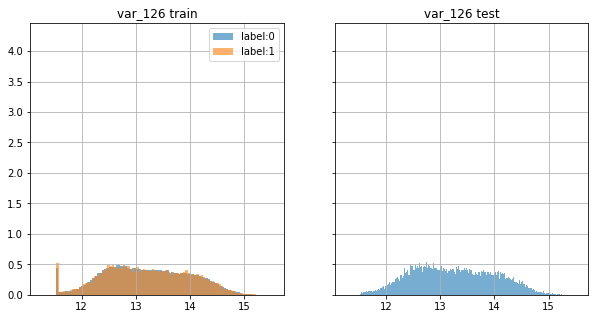

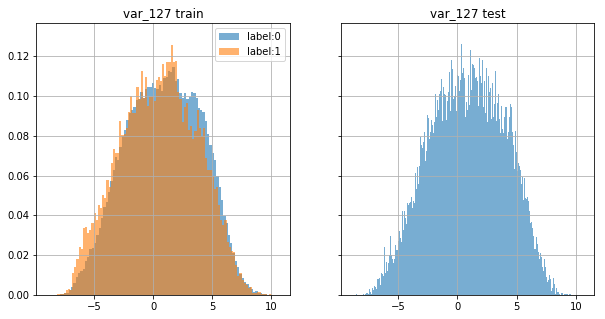

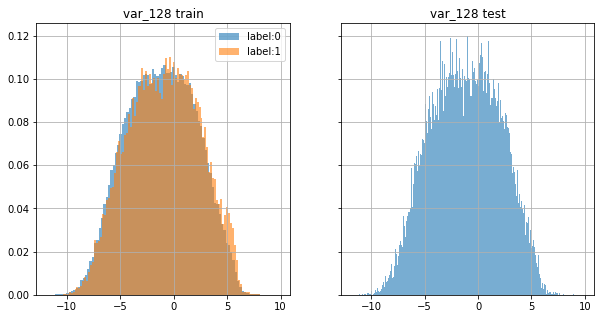

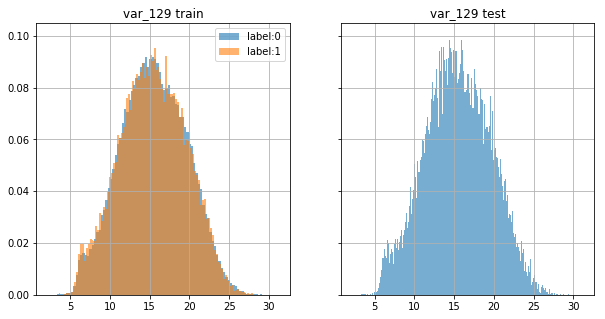

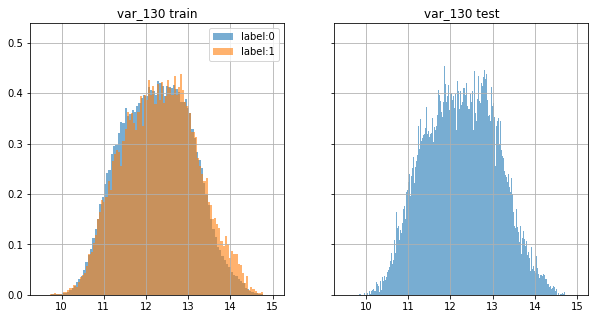

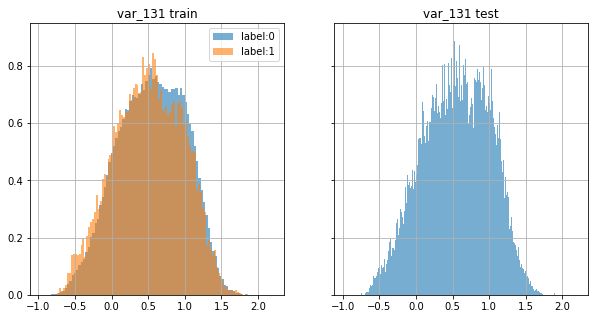

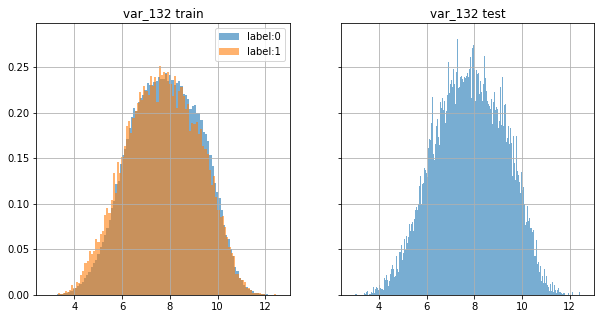

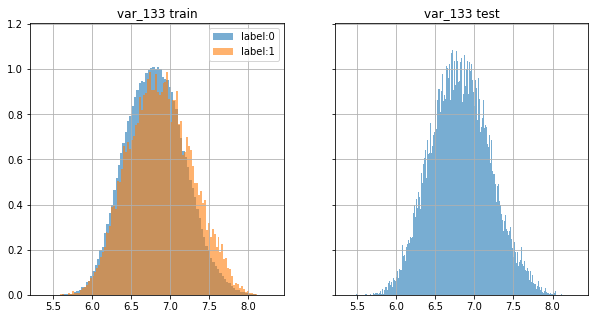

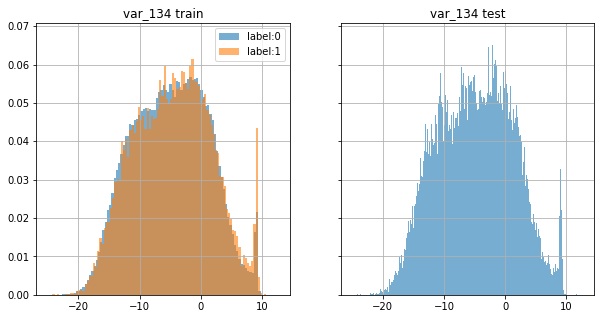

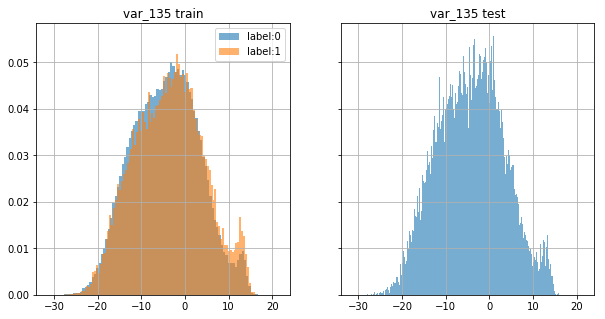

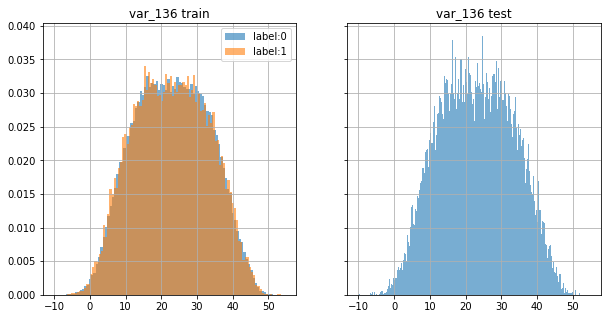

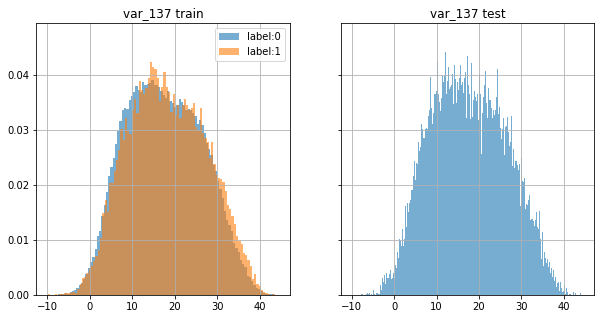

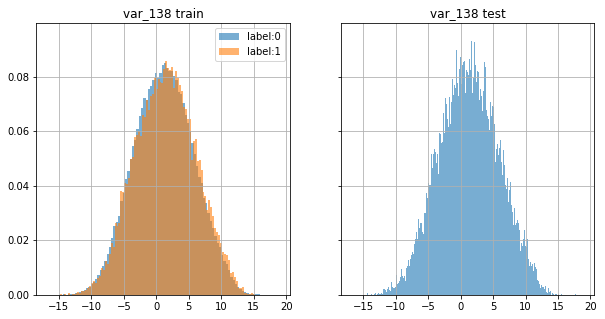

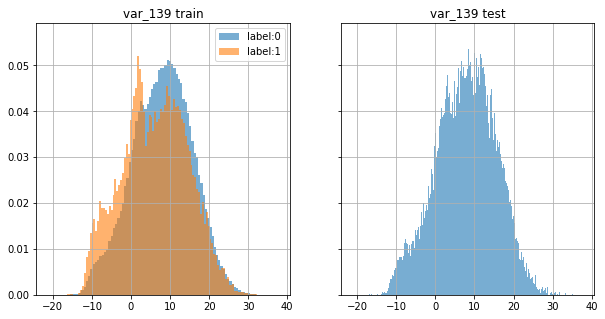

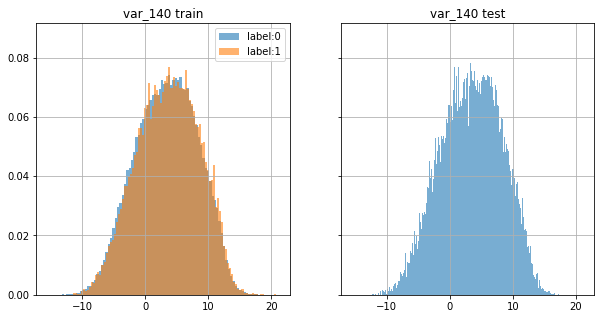

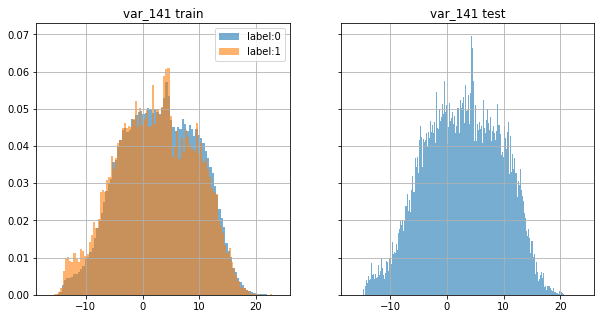

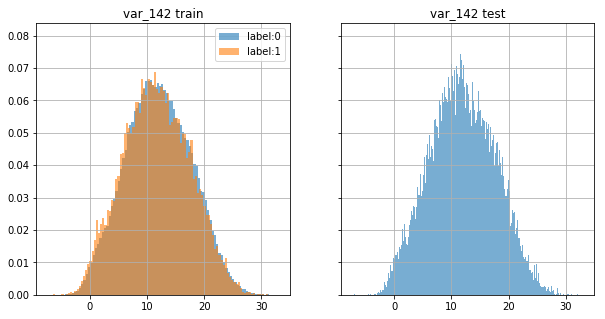

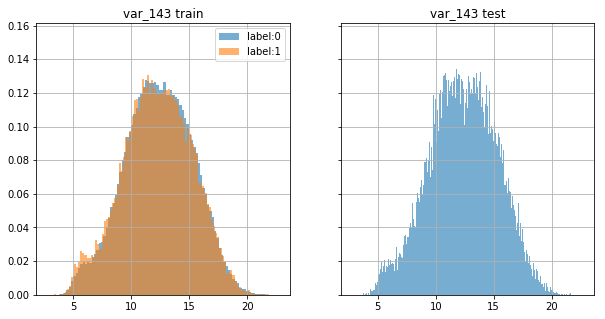

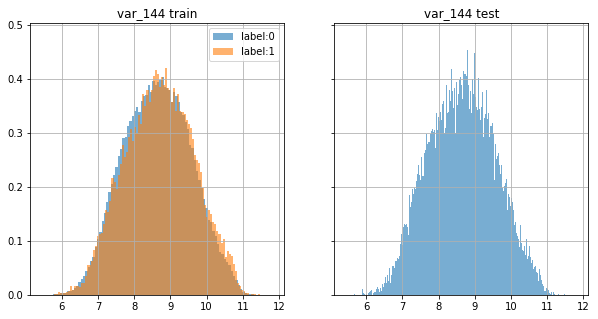

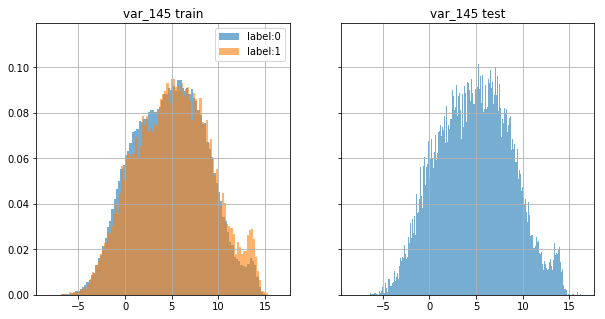

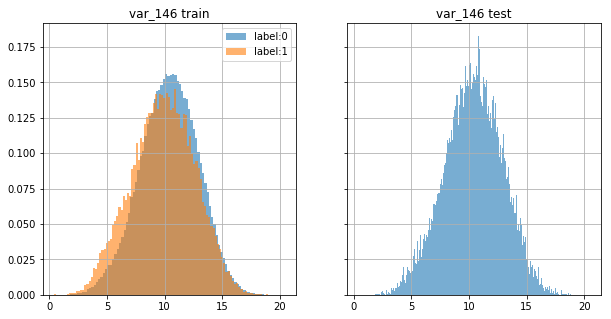

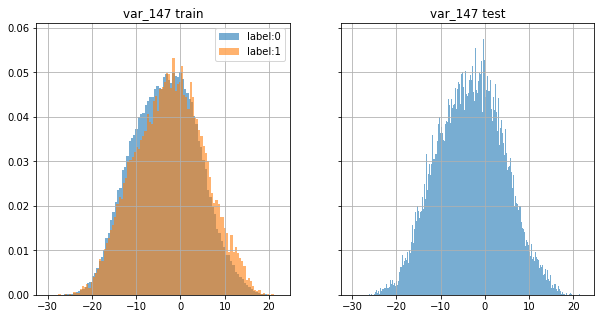

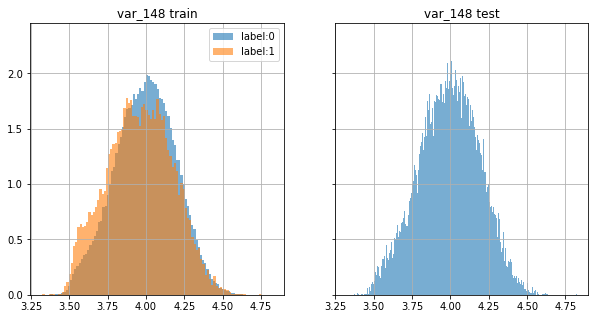

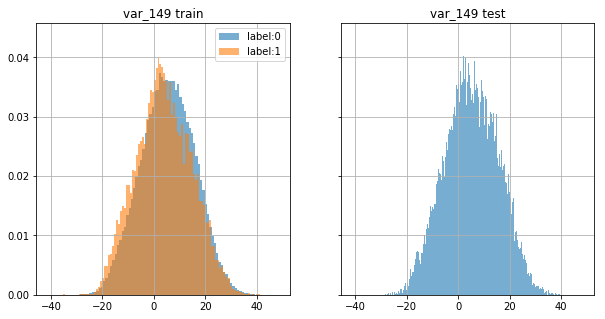

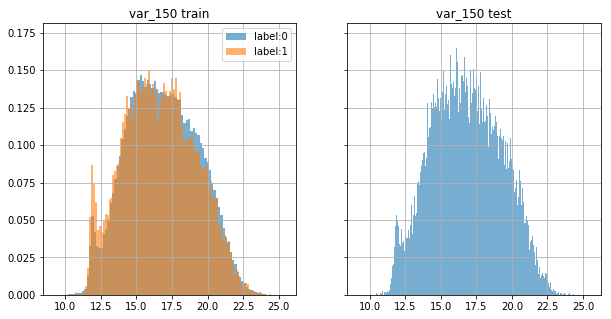

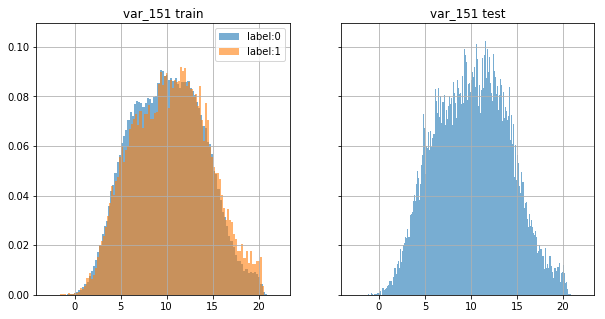

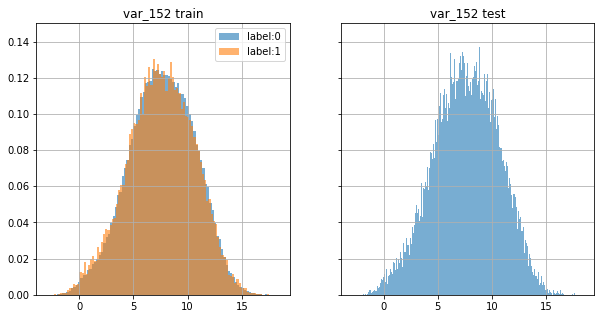

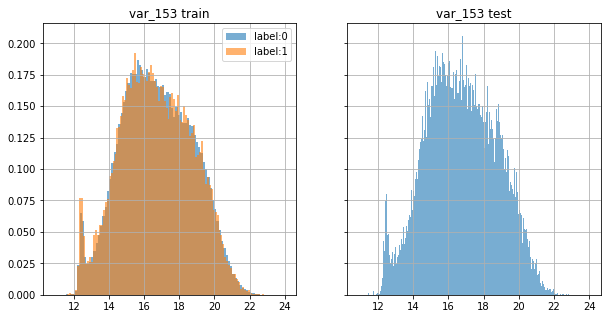

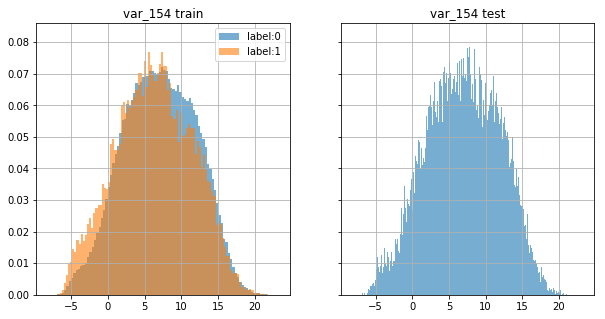

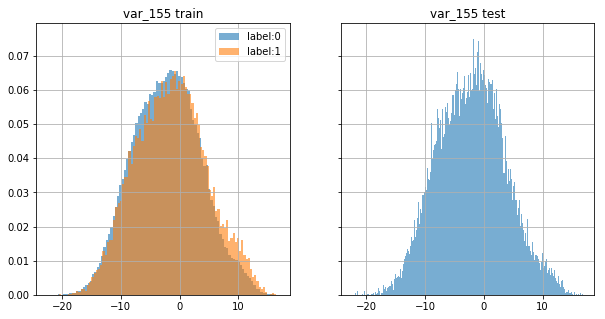

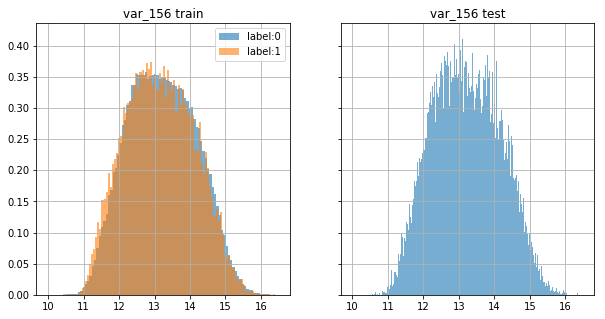

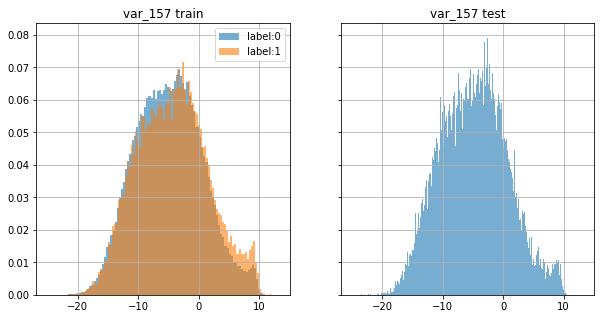

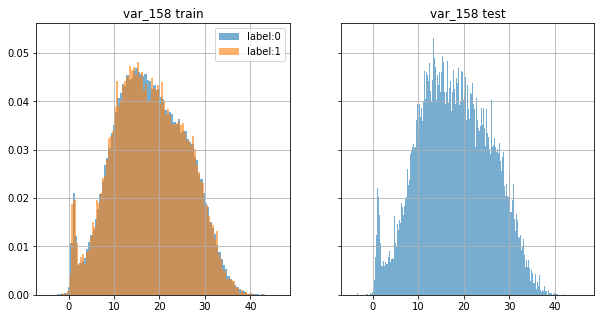

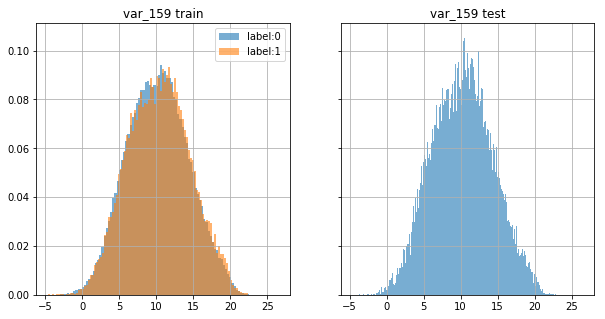

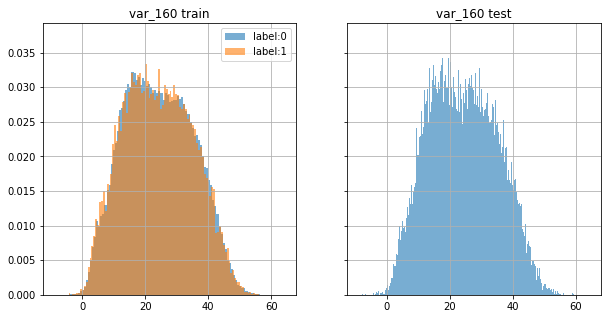

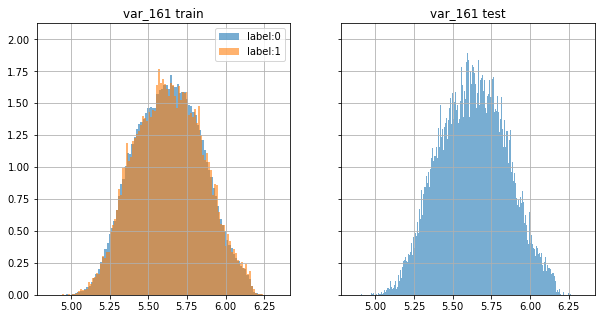

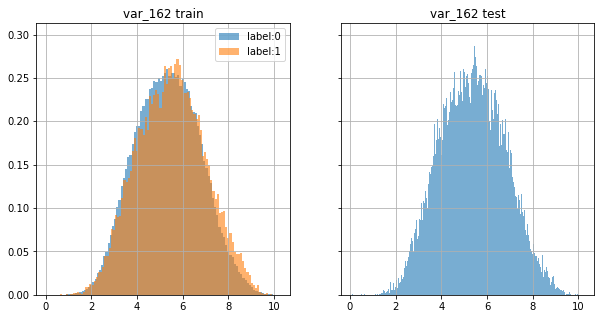

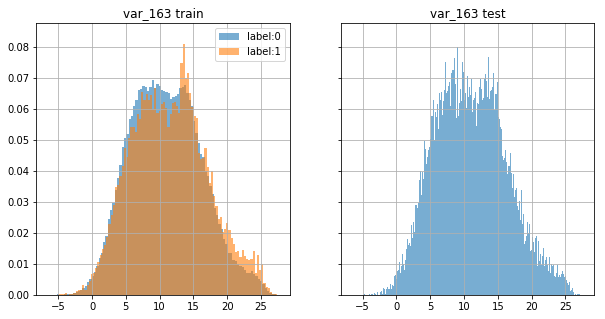

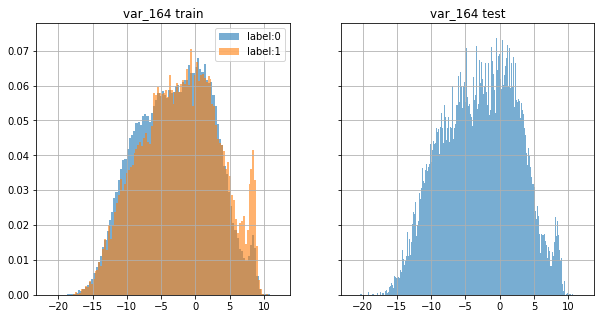

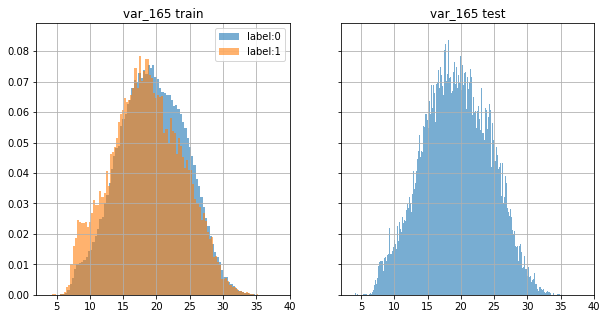

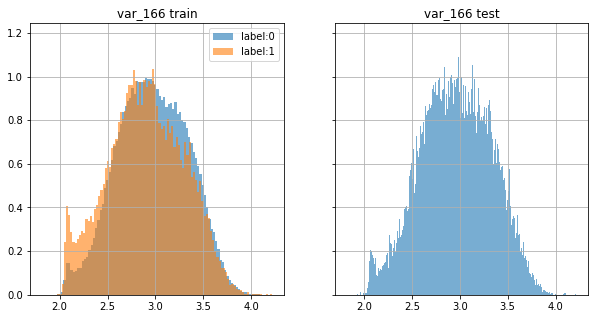

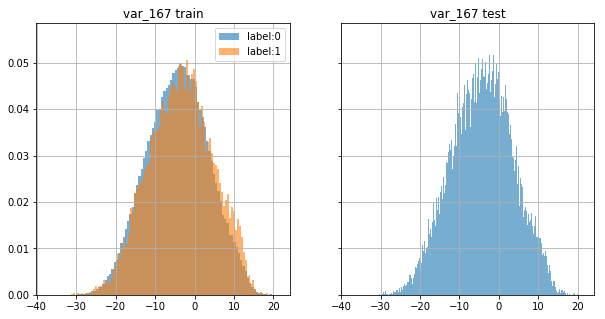

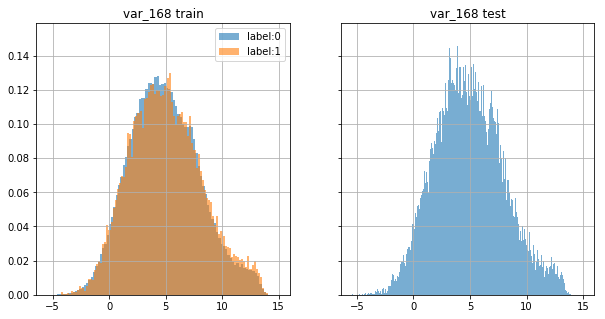

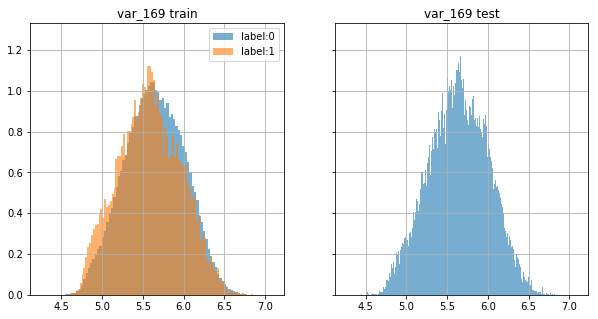

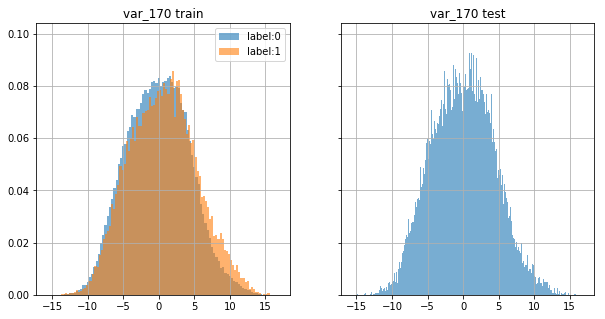

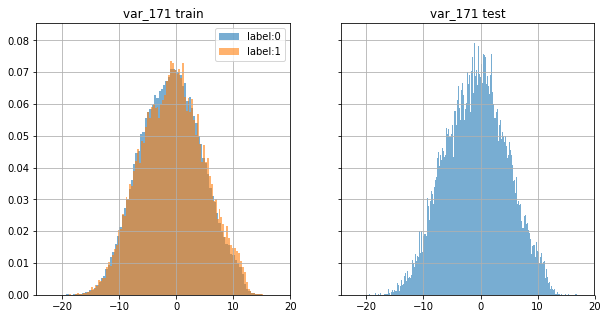

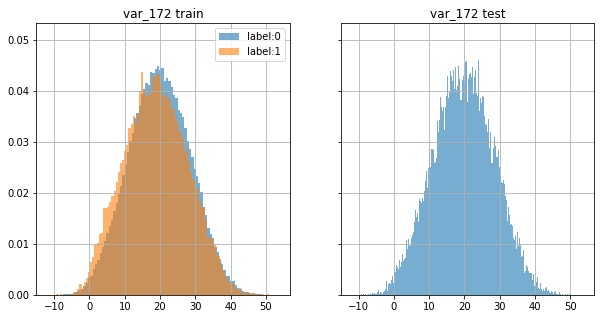

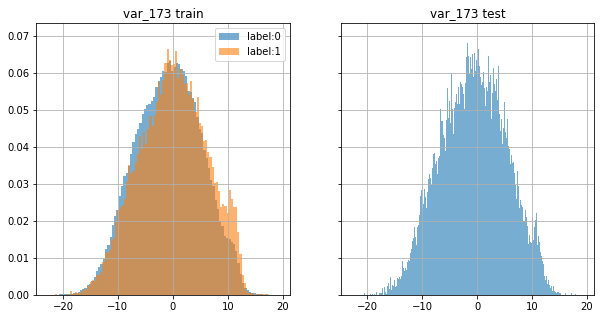

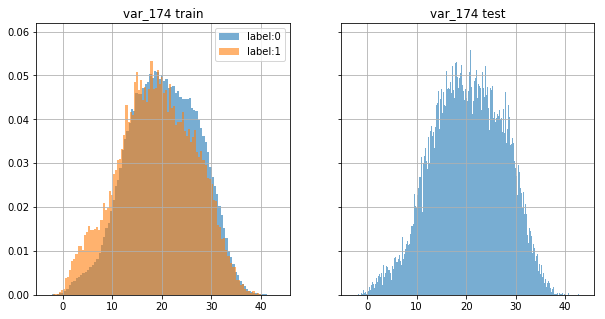

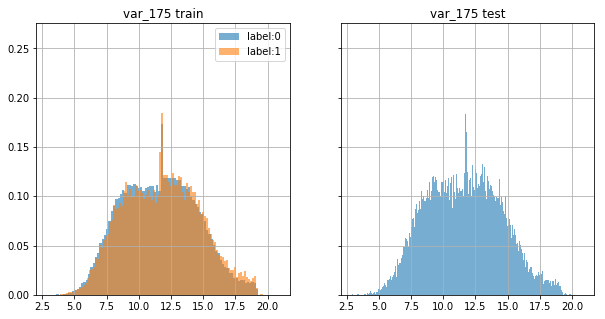

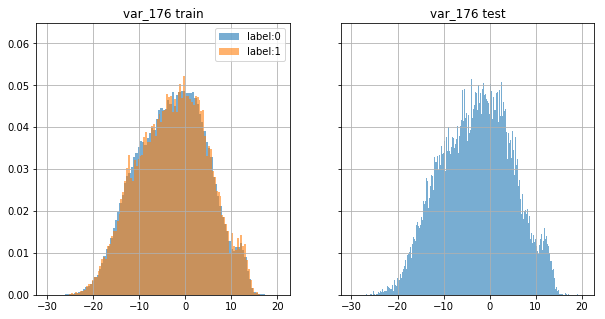

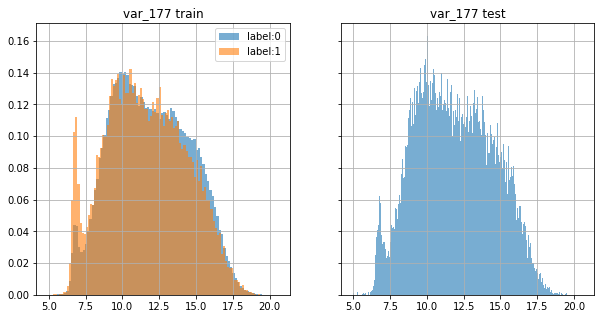

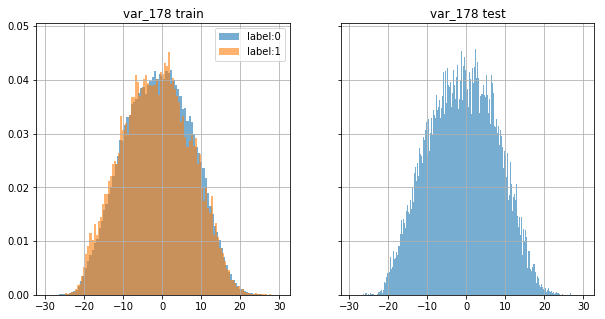

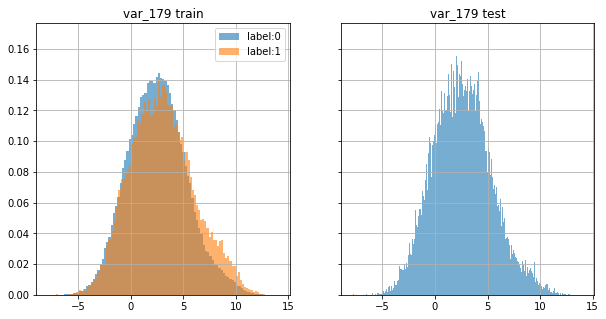

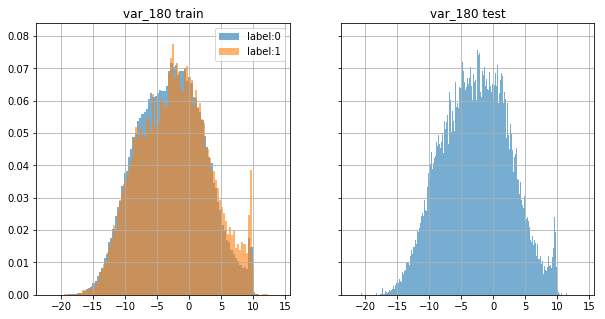

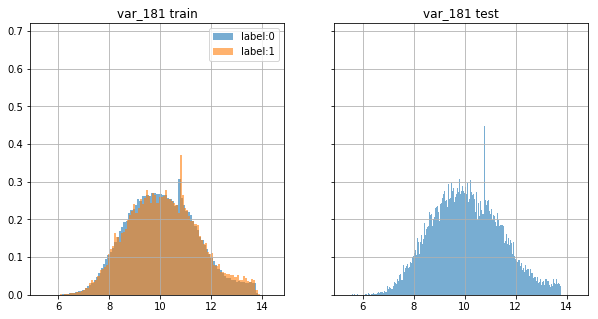

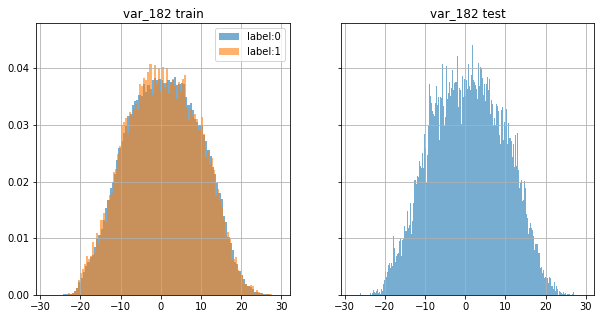

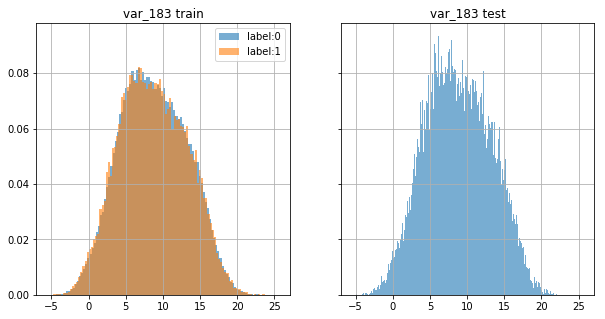

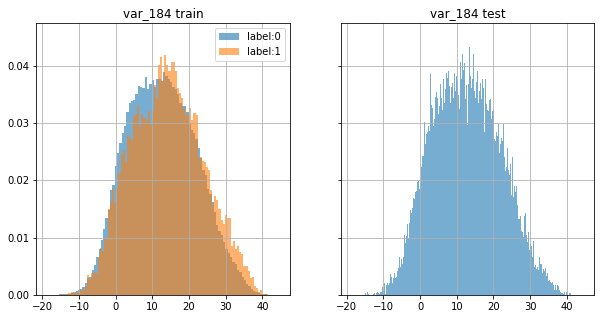

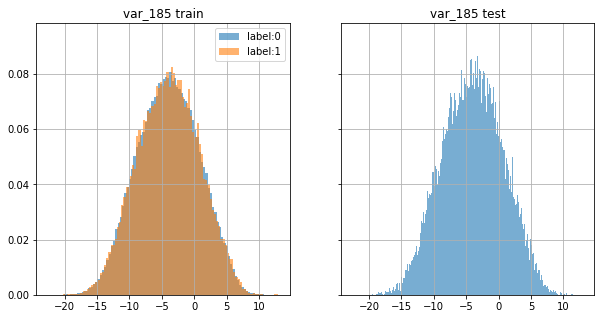

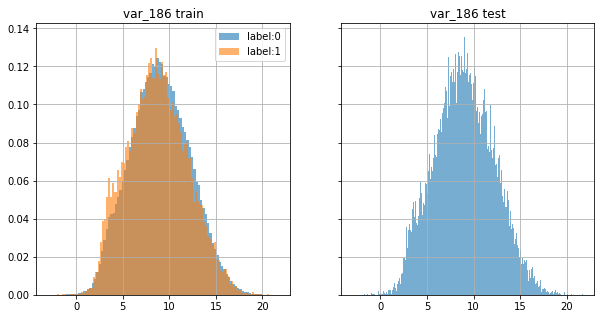

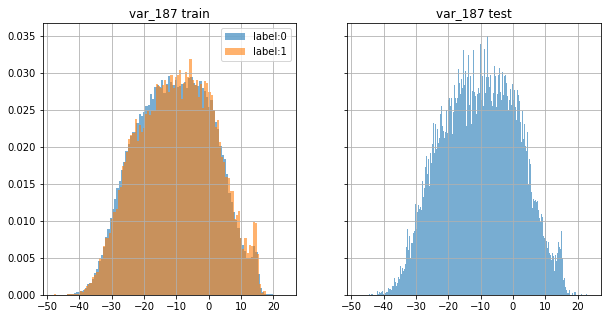

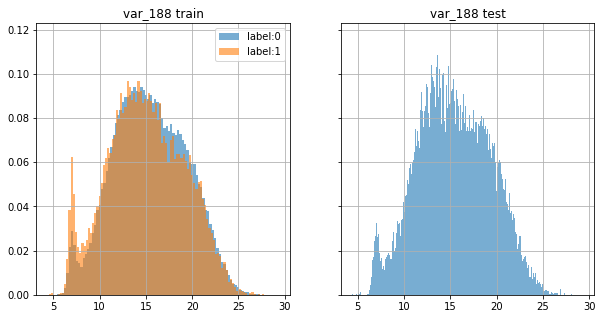

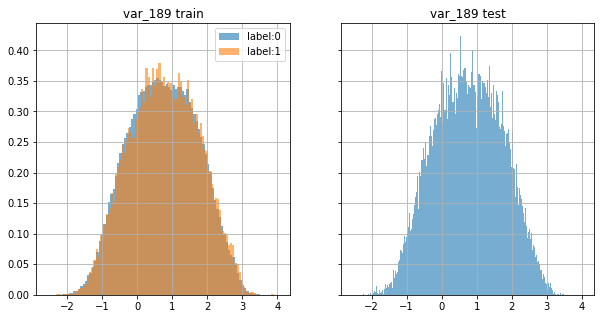

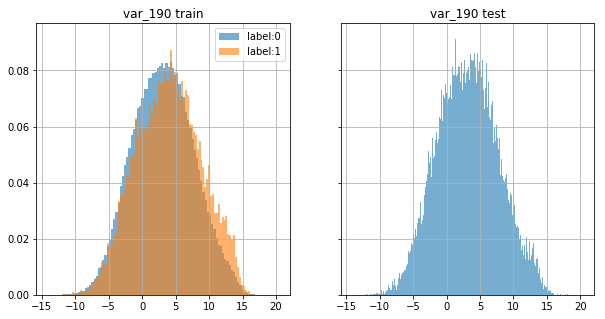

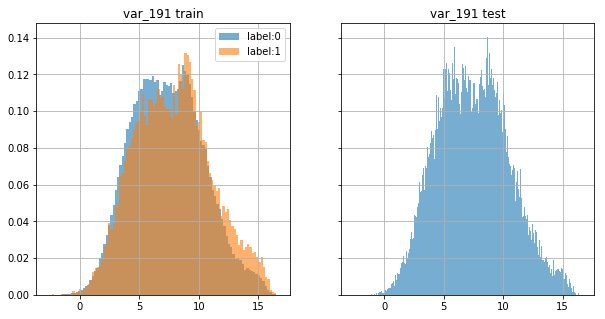

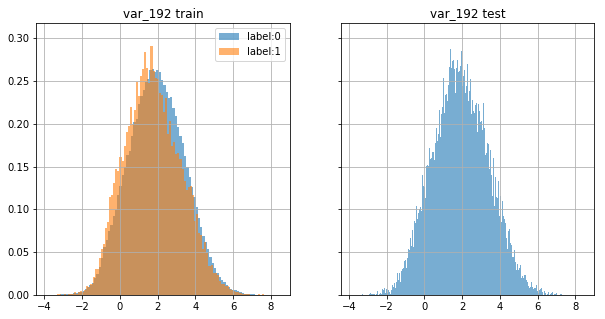

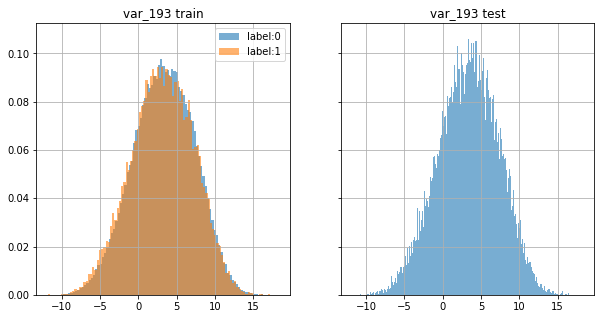

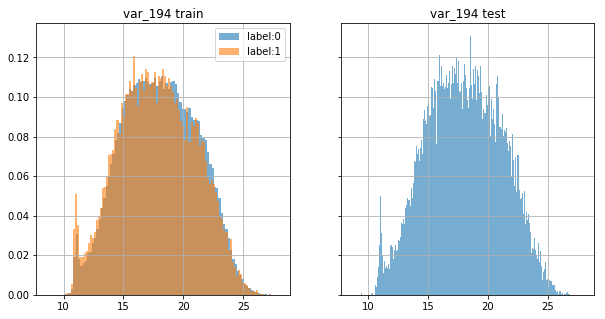

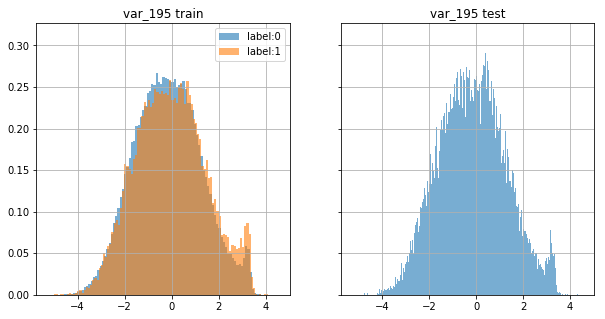

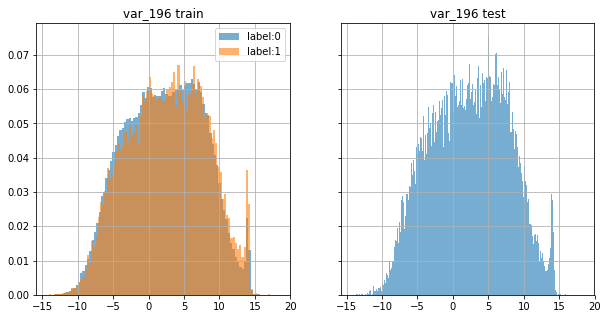

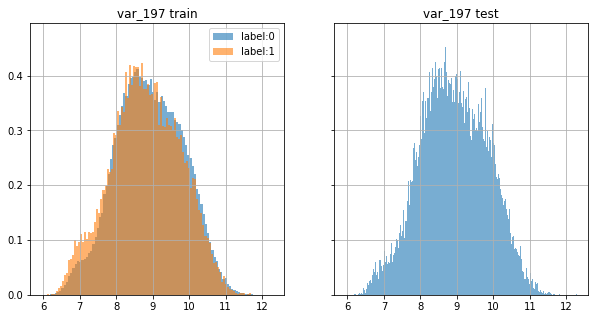

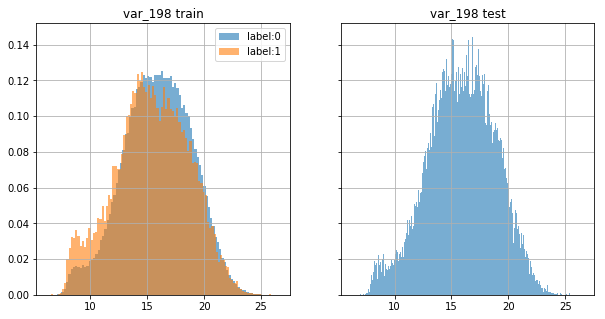

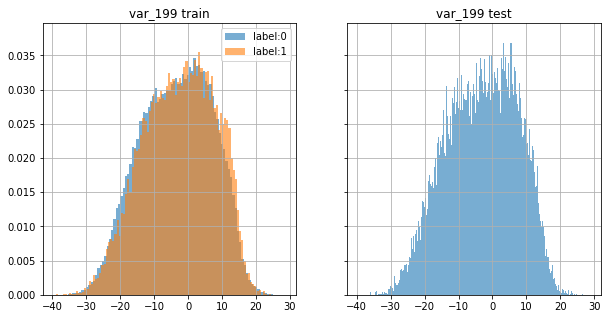

In [6]:

for feature in tqdm(features):
    train_label0 = train_df.query("target==0")[feature]
    train_label1 = train_df.query("target==1")[feature]
    test = test_df[feature]
    
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

    axL.hist(train_label0, label="label:0", bins=100, density=True, alpha=0.6)
    axL.hist(train_label1, label="label:1", bins=100, density=True, alpha=0.6)
    axL.set_title('{} train'.format(feature))
    axL.legend()
    axL.grid(True)

    axR.hist(test, bins=1000, density=True, alpha=0.6)
    axR.set_title('{} test'.format(feature))
    axR.grid(True)
    fig.show()
    

In [215]:
def add_indicator(df):
    df["var_12_binary"] = (df["var_12"].round(2) == 13.55).map(lambda x: int(x))
    df["var_53_binary"] = df["var_53"].round(2).map(lambda x: 1 if x  <= 7.80 and x >= 7.77 else 0)
    df["var_81_binary"] = df["var_81"].round(2).map(lambda x: 1 if x  <= 9.16 and x >= 9.17 else 0)
    df["var_108_binary"] = (df["var_108"].round(2) == 14.20).map(lambda x: int(x))
    df["var_134_binary"] = (df["var_134"].round(2) == 9.16).map(lambda x: int(x))
    df["var_180_binary"] = (df["var_180"].round(2) == 9.45).map(lambda x: int(x))

    
add_indicator(train_df)
add_indicator(test_df)

In [216]:
for df in [train_df, test_df]:
    df["sum"] = train_df.sum(axis=1)

In [131]:
test_df["var_12_binary"].sum()

1714

In [168]:
pd.options.display.max_columns = 500
pd.set_option("display.max_rows", 1001)
pd.options.display.notebook_repr_html = True
# 13.545 in pd.cut(train_df["var_12"], bins=50).map(lambda x:x.left)
display(train_df.query("target==1")["var_181"].round(2).value_counts())
# print(train_df.query("target==0")["var_53"].round(2).value_counts())


10.80    1027
10.79    1005
10.81     543
9.76      537
9.49      535
10.78     517
9.92      515
9.53      514
10.24     512
10.16     511
9.68      510
9.85      508
10.03     507
9.60      506
9.65      503
10.26     503
9.81      502
10.11     501
9.83      501
9.33      500
9.89      500
9.72      499
10.10     498
10.04     498
9.64      497
9.67      497
9.39      496
10.06     496
9.30      495
9.73      494
9.84      493
10.02     492
9.46      492
10.36     491
9.86      491
9.94      491
9.95      490
10.13     489
10.01     487
9.98      486
10.30     485
9.93      484
9.96      484
10.18     484
9.45      483
9.78      482
9.88      481
10.00     481
9.54      481
9.57      480
9.59      480
9.70      479
9.27      479
9.22      478
9.42      478
10.25     478
9.50      477
9.44      477
9.14      477
9.91      477
9.75      476
9.63      476
9.79      475
9.82      475
9.32      475
10.08     475
9.80      475
9.29      474
10.15     474
9.61      473
10.65     473
9.71  

In [19]:
target = [1,2,3,4,5,1,3]
np.unique(target, return_counts=True, return_index=True)

(array([1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4]), array([2, 1, 2, 1, 1]))

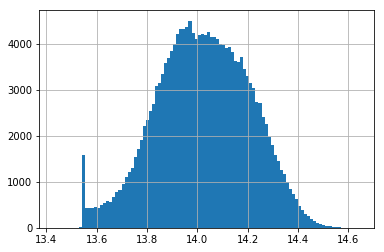

In [78]:
pd.cut(train_df.query("target==0")["var_12"], bins=100).map(lambda x:x.left).hist(bins=100);

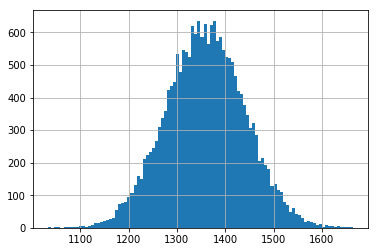

In [182]:
train_df.query("target==1").sum(axis=1).hist(bins=100)

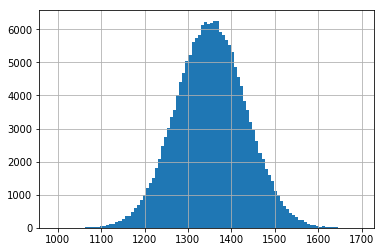

In [181]:
train_df.query("target==0").sum(axis=1).hist(bins=100)

In [233]:
def add_statistics(var_name):
    feature_mean0 = np.mean(train_df.query("target==0")[var_name])
    feature_mean1 = np.mean(train_df.query("target==1")[var_name])
    
#     print("{} label0 mean:{} label1 mean:{}".format(var_name, feature_mean0, feature_mean1))
    
    train_df["{}_mean_diff_0".format(var_name)] = train_df[var_name] - feature_mean0
    train_df["{}_mean_diff_1".format(var_name)] = train_df[var_name] - feature_mean1
    test_df["{}_mean_diff_0".format(var_name)] = test_df[var_name] - feature_mean0
    test_df["{}_mean_diff_1".format(var_name)] = test_df[var_name] - feature_mean1

In [234]:
for i in range(200):
    add_statistics("var_{}".format(i))

In [3]:
sampledf = True #Uses a specific amount of rows , use this for faster training and testing functionalities and features
frac_sample = 0.1 #fraction of the data to use
augmnt = False #use an augmented data set
fold_train = True
agmnt_between = False #augment training data between folds
kfold_shuffle = False
use_perc = False #using percentiles in feature engineering
log_transf = False
sq_data = True
dim_red = False
n_components = 60
standradize=True
train_between = True
#--------------------------------------------------------------
#Keras options
#Weighted Classes when training 
weighted = False
balanced = False #balanced weights
#-------------------
#train test Split
tst_size = 0.2

sub_name = 'submission'
print('Options Active: \n\t SampledDF: {} frac: {} \n\t Augmentation: {}\n\t Weighted: {}\n\t Balanced: {}\
      \n\t agmnt_between:{}\n\t Percentiles: {}\n\t LOG_Transform: {}\n\t PCA: {}\n\t Square: {}\n\t Standradize: {}\n\t Train_Between: {}'.format(sampledf,frac_sample,augmnt,
                                                                                                                             weighted,balanced,agmnt_between,use_perc,log_transf
                                                                                                                            ,dim_red,sq_data,standradize,train_between))

Options Active: 
	 SampledDF: True frac: 0.1 
	 Augmentation: False
	 Weighted: False
	 Balanced: False      
	 agmnt_between:False
	 Percentiles: False
	 LOG_Transform: False
	 PCA: False
	 Square: True
	 Standradize: True
	 Train_Between: True


In [13]:
def feature_creation(df, idx, use_perc,perc_list,name_num='_1'):
    #data metrics
    print('  * Loading new data metrics: ', name_num)
    df['sum'+name_num] = df[idx].sum(axis=1)  
    df['min'+name_num] = df[idx].min(axis=1)
    df['max'+name_num] = df[idx].max(axis=1)
    df['mean'+name_num] = df[idx].mean(axis=1)
    df['std'+name_num] = df[idx].std(axis=1)
    df['skew'+name_num] = df[idx].skew(axis=1)
    df['kurt'+name_num] = df[idx].kurtosis(axis=1)
    df['med'+name_num] = df[idx].median(axis=1)
    #moving average
    print('  * Loading moving average metric: ', name_num)
    df['ma'+name_num] =  df[idx].apply(lambda x: np.ma.average(x), axis=1)
    #percentiles
    if use_perc:
        print('  * Loading percentiles: ', name_num)
        for i in perc_list:
            df['perc_'+str(i)] =  df[idx].apply(lambda x: np.percentile(x, i), axis=1)

    #interactions
    #coming..

perc_size  = 0
perc_list = [1,2,5,10,25,50,60,75,80,85,95,99]
if use_perc:
    perc_size = len(perc_list)
start_time = time.time()

for i, df in enumerate([train_df, test_df]):
    print('Loading more features for df: {}/{}'.format(i+1,3))
    print('Creating Metrics Part 1')
    features_1 = train_df.columns.values[2:202]
    feature_creation(df,features_1,use_perc,perc_list,name_num='_1') #adding columns using the train features (#200)
    print('Creating Metrics Part 2')
    features_2 = train_df.columns.values[2:211+perc_size] #all features included the ones added
    feature_creation(df,features_2,use_perc,perc_list,name_num='_2') #adding columns using the train features + the new features
    #drop repeated columns
    df.drop(['min_2','max_2'],axis=1,inplace=True)
    print('-'*50)
    
if log_transf:
    print('Loading log transformations')
    for i in range(200):
        train_df['var_log_'+str(i)] = np.log(train_df['var_'+str(i)])
        test_df['var_log_'+str(i)] = np.log(test_df['var_'+str(i)])

if sq_data:
    print('Loading Squared data..')
    for i in range(200):
        train_df['var_sq_'+str(i)] = np.square(train_df['var_'+str(i)])
        test_df['var_sq_'+str(i)] = np.square(test_df['var_'+str(i)])
    
print('Features loaded !')
print("Execution --- %s seconds ---" % (time.time() - start_time))
print('Train df: ', train_df.columns)
print('Test df: ', test_df.columns)
print('Number of Features: ', len(train_df.columns[2:]))

Loading more features for df: 1/3
Creating Metrics Part 1
  * Loading new data metrics:  _1
  * Loading moving average metric:  _1
Creating Metrics Part 2
  * Loading new data metrics:  _2
  * Loading moving average metric:  _2
--------------------------------------------------
Loading more features for df: 2/3
Creating Metrics Part 1
  * Loading new data metrics:  _1
  * Loading moving average metric:  _1
Creating Metrics Part 2
  * Loading new data metrics:  _2
  * Loading moving average metric:  _2
--------------------------------------------------
Loading Squared data..
Features loaded !
Execution --- 128.87761425971985 seconds ---
Train df:  Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_sq_190', 'var_sq_191', 'var_sq_192', 'var_sq_193', 'var_sq_194',
       'var_sq_195', 'var_sq_196', 'var_sq_197', 'var_sq_198', 'var_sq_199'],
      dtype='object', length=418)
Test df:  Index(['ID_code', 'var_0', '

In [8]:
# cat_features = ['var_12', 'var_13', 'var_108', 'var_126', 'var_68']
# cat_features_num = [12,13, 37,40,53,68, 80,81,89,92,99,101,108,123,126,134,164,177,180,187,188,194,196]
# cat_features = ["var_{}".format(num) for num in cat_features_num]
# print("categorical : ", cat_features)

# for idx, feature in enumerate(cat_features):
#     hist, bin_edges = np.histogram(train_df[feature], bins=1000, density=True)
#     train_df['test_' + feature] = [hist[np.searchsorted(bin_edges, ele)-1] for ele in train_df[feature]]    
#     test_df['test_' + feature] = [hist[np.searchsorted(bin_edges, ele)-1] for ele in train_df[feature]]
    
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

# print(features)

In [84]:



####

features = []

for idx in unique_features:
    features.append("var_{}".format(idx))
####

print(features)

['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_7', 'var_8', 'var_10', 'var_11', 'var_13', 'var_14', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_24', 'var_26', 'var_27', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_51', 'var_52', 'var_54', 'var_55', 'var_56', 'var_58', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_67', 'var_69', 'var_70', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_92', 'var_94', 'var_96', 'var_97', 'var_99', 'var_100', 'var_101', 'var_102', 'var_104', 'var_106', 'var_107', 'var_109', 'var_110', 'var_112', 'var_113', 'var_115', 'var_116', 'var_117', 'var_118', 'var_119', 'var_120', 'var_121', 'var_122', 'var_123', 'var_124

### deal with imbalanced-data

```
! git clone https://github.com/scikit-learn-contrib/imbalanced-learn.git
! cd imbalanced-learn
! python setup.py install
```

In [4]:
from imblearn.over_sampling import SMOTE

def SMOTE_upsampler(X_train, y_train, ratio=0.3):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    sm = SMOTE(random_state=42, sampling_strategy=ratio, n_jobs=-1)
    X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
    return (X_train_resampled, y_train_resampled)

In [78]:
from imblearn.under_sampling import RandomUnderSampler

def undersample(X_train, y_train, seed=0):
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=seed)
    X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)
    return (X_train_resampled, y_train_resampled )

In [38]:
# Data augmentation
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

### Hyperparmeter Search

In [ ]:
data = np.array(train_df[features])
target_arr = np.asarray(train_df['target'])

dev_x, test_x, dev_y, test_y = train_test_split(data, target_arr, test_size=0.25, stratify=target, random_state=2018)
train_x, val_x, train_y, val_y = train_test_split(dev_x, dev_y, test_size=0.3, stratify=dev_y,  random_state=2018)

def objective(trial):
    param = {
        "pca_type" : trial.suggest_categorical('pca_type', ['linear', 'kernel']),
#         'pca_dim' : trial.suggest_int('pca_dim', 1, 100),
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'num_iterations' : 10000,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': 3,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 1000),
        'max_depth' : trial.suggest_int('max_depth', -1, 100)
    }
        

    
    print("train, val, test:  {}, {}, {}".format(train_x.shape, val_x.shape, test_x.shape))
    
    dtrain = lgb.Dataset(train_X, label=train_y)
    dval = lgb.Dataset(val_X, label=val_y)

    

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    gbm = lgb.train(param, dtrain, early_stopping_rounds=100, valid_sets = [dtrain, dval], verbose_eval=1000)
    preds = gbm.predict(test_x,  num_iteration=gbm.best_iteration)
    auc_score = roc_auc_score(test_y, preds)
    return 1.0 - auc_score


if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=50)

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

train, val, test:  (105000, 200), (45000, 200), (50000, 200)
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.968792	valid_1's auc: 0.852637
[2000]	training's auc: 0.991746	valid_1's auc: 0.875854
[3000]	training's auc: 0.998006	valid_1's auc: 0.885266
[4000]	training's auc: 0.999636	valid_1's auc: 0.889669
[5000]	training's auc: 0.999954	valid_1's auc: 0.892089
[6000]	training's auc: 0.999996	valid_1's auc: 0.893445
[7000]	training's auc: 1	valid_1's auc: 0.894023
Early stopping, best iteration is:
[7211]	training's auc: 1	valid_1's auc: 0.894138


[I 2019-03-03 21:43:07,165] Finished a trial resulted in value: 0.11350206398118623. Current best value is 0.11350206398118623 with parameters: {'pca_type': 'linear', 'pca_dim': 4, 'boosting': 'gbdt', 'num_leaves': 464, 'learning_rate': 0.0024376045374634877, 'min_data_in_leaf': 357, 'max_depth': 52}.


In [11]:
param = trial.params
param['objective'] = 'binary'
param['metric'] = 'auc'
param

{'boosting': 'gbdt',
 'learning_rate': 0.027065938118566835,
 'max_depth': 1,
 'metric': 'auc',
 'min_data_in_leaf': 733,
 'num_leaves': 939,
 'objective': 'binary',
 'pca_dim': 16}

In [8]:
param = {'boosting': 'gbdt',
 'learning_rate': 0.027065938118566835,
 'max_depth': 1,
 'metric': 'auc',
 'min_data_in_leaf': 733,
 'num_leaves': 939,
 'objective': 'binary',
 'pca_dim': 0}
param['objective'] = 'binary'
param['metric'] = 'auc'

In [6]:
param = {'boosting': 'gbdt',
 'learning_rate': 0.02,
 'max_depth': 2,
 'metric': 'auc',
 'min_data_in_leaf': 750,
 'num_leaves': 3,
 'objective': 'binary',
 'pca_dim': 0,
'feature_fraction' : 0.8}
param['objective'] = 'binary'
param['metric'] = 'auc'

In [27]:
# from kernel : https://www.kaggle.com/niteshx2/beginner-explained-lgb-2-leaves-augment
param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 10,
    "learning_rate" : 0.005,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    #"min_sum_hessian_in_leaf" : 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 0,
    "verbosity" : 1,
    "seed": 0,
    "pca_dim" : 0
}

In [218]:
# Model parameters
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 3,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
#     "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 2019,
    "verbosity" : 1,
    "seed": 2019,
    "pca_dim" : 0,
    "max_bin" : 100}


In [9]:
# https://www.kaggle.com/tanakin/tutorial-keras-lgbm-aug-feature-eng-sampling-pr/edit
param = {
    'bagging_freq': 4, #handling overfitting
    'bagging_fraction': 0.2,#handling overfitting - adding some noise
    #'boost': 'dart',
    #'boost': 'goss',
     'boost_from_average' :False,
     'boost': 'gbdt',   
    'feature_fraction': 0.15, #handling overfitting
    'learning_rate': 0.01, #the changes between one auc and a better one gets really small thus a small learning rate performs better
    'max_depth': 2, 
    'metric':'auc',
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'xentropy', 
    'verbosity':0,
    "bagging_seed" : 12,
    "seed": 2,
    }

### train lgbm

In [11]:

train_, val_, train_y_, val_y_ = train_test_split(train_df, target, test_size=0.2, random_state=20)
train_X_ = np.array(train_[features])
# train_y_ = np.array(train_["target"])
val_X_ = np.array(val_[features])
# val_y_ = np.array(val_["target"])

test_X = np.array(test_df[features])

# scaler = StandardScaler()
# scaler.fit(np.vstack((train_X_, val_X_)))
# train_X_ = scaler.transform(train_X_)
# val_X_ = scaler.transform(val_X_)

# test_scaler = StandardScaler()
# test_X = test_scaler.fit_transform(test_X)

feature_importance_df = pd.DataFrame()
split_num = 1

for i in range(split_num):
#     train_X_sampled, train_y_sampled = undersample(train_X_, train_y_, seed=i*5)
    train_X_sampled, train_y_sampled = train_X_, train_y_

    trn_data = lgb.Dataset(train_X_sampled, label=train_y_sampled)
    val_data = lgb.Dataset(val_X_, label=val_y_)

    
    print("train:{}, val:{}".format(train_X_sampled.shape, val_X_.shape))
    c = Counter(train_y_sampled)
    print("training class ratio: ", c)
    
    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
    oof = clf.predict(val_X_, num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions = clf.predict(test_X, num_iteration=clf.best_iteration)

print("Validation score: {:<8.5f}".format(roc_auc_score(val_y_, oof)))


train:(160000, 1195), val:(40000, 1195)
training class ratio:  Counter({0: 143884, 1: 16116})
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.842756	valid_1's auc: 0.836092
[2000]	training's auc: 0.873999	valid_1's auc: 0.863561
[3000]	training's auc: 0.889411	valid_1's auc: 0.876452
[4000]	training's auc: 0.898452	valid_1's auc: 0.884003
[5000]	training's auc: 0.904549	valid_1's auc: 0.888873
[6000]	training's auc: 0.90908	valid_1's auc: 0.892186
[7000]	training's auc: 0.912608	valid_1's auc: 0.894263
[8000]	training's auc: 0.915642	valid_1's auc: 0.895606
[9000]	training's auc: 0.91824	valid_1's auc: 0.896727
[10000]	training's auc: 0.920701	valid_1's auc: 0.89721
[11000]	training's auc: 0.922776	valid_1's auc: 0.897653
[12000]	training's auc: 0.924753	valid_1's auc: 0.897894
[13000]	training's auc: 0.926626	valid_1's auc: 0.898056
[14000]	training's auc: 0.928495	valid_1's auc: 0.898011
[15000]	training's auc: 0.930177	valid_1's auc: 0.897901

In [205]:
roc_auc_score(val_y_, oof)

0.8960467168614477

In [195]:
test_X = np.array(test_df[features])

predictions = clf.predict(test_X, num_iteration=clf.best_iteration)


In [194]:
imp_df_original = fold_importance_df.groupby("feature").mean().sort_values('importance')[-1::-1]
display(imp_df_original)


,importance,fold
feature,,
var_53,273,30
var_6,239,30
var_12,238,30
var_33_mean_diff_0,232,30
var_166,228,30
var_81_mean_diff_1,226,30
var_81,226,30
var_127_mean_diff_0,222,30
var_121_mean_diff_0,221,30


### train MLP

In [235]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MLP(nn.Module):

    def __init__(self, input_dim=2, hidden_units=100, num_hidden_layers=3):
        super(MLP, self).__init__()
        self.first_fc = nn.Linear(input_dim, hidden_units)
        layers = [nn.Linear(hidden_units, hidden_units) for _ in range(num_hidden_layers-1)]
        self.middle_layers = nn.ModuleList(layers)
        self.final_fc = nn.Linear(hidden_units, 2)

        self.relu = nn.ReLU(inplace=True)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.first_fc(x))
        for i in range(len(self.middle_layers)):
            x = self.relu(self.middle_layers[i](x))
#         x = self.logsoftmax(self.final_fc(x))
        x = self.final_fc(x)
        return x


In [241]:
train_, val_ = train_test_split(train_df, test_size=0.2, random_state=20)
train_X_ = np.array(train_[features])
train_y_ = np.array(train_["target"])
val_X_ = np.array(val_[features])
val_y_ = np.array(val_["target"])
test_X = np.array(test_df[features])

scaler = StandardScaler()
scaler.fit(np.vstack((train_X_, val_X_)))
train_X_ = scaler.transform(train_X_)
val_X_ = scaler.transform(val_X_)

test_scaler = StandardScaler()
test_X = test_scaler.fit_transform(test_X)

device = "cuda:0"
max_epoch = 100

train_X  = torch.tensor(train_X_, dtype=torch.float)
train_y  = torch.tensor(train_y_, dtype=torch.long)
val_X  = torch.tensor(val_X_, dtype=torch.float)
val_y  = torch.tensor(val_y_, dtype=torch.long)

datasize = {"train": len(train_X), "val": len(val_X)}

train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_X, val_y)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

model = MLP(input_dim=train_X.size()[1], hidden_units=200, num_hidden_layers=2).to(device)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lowest_val_loss = 10000000


for epoch in tqdm(range(max_epoch)):

    model.train()

    train_loss = 0
    val_loss = 0
    for i, train_data in enumerate(train_loader):
        data, labels = train_data
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        loss = loss_func(outputs, labels)

        train_loss += loss.item()*data.size()[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= datasize["train"]
    
    model.eval()
    val_pred = []
    for i, val_data in enumerate(val_loader):
        data, labels = val_data
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        val_pred.extend(outputs.cpu().detach().numpy()[:, 1])
        
        loss = loss_func(outputs, labels)

        val_loss += loss.item()*data.size()[0]
    
    val_loss /= datasize["val"]
    
    
    if lowest_val_loss > val_loss:
        best_params = model.state_dict()
        lowest_val_loss = val_loss
        best_val_pred = val_pred
        print("epoch:{} train loss:{} val loss:{}".format(epoch, train_loss, val_loss))

epoch:0 train loss:0.24891953144073486 val loss:0.2429556340932846
epoch:1 train loss:0.23216103953123093 val loss:0.23924333488941193


KeyboardInterrupt: 

In [242]:
# Validation Score
roc_auc_score(val_y_, best_val_pred)

0.8485139336409143

In [ ]:
model.load_state_dict(best_params)
model.to(device)

test_X  = torch.tensor(test_X, dtype=torch.float)
pseudo_y = [0] * len(test_X)
test_dataset = torch.utils.data.TensorDataset(test_X, pseudo_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    model.eval()

    correct = 0
    y_score = []
    y_pred = []
    img_path = []
    y = []
    i = 0

    for idx, data in enumerate(tqdm(test_iter)):
        path, inputs, labels = data
        img_path.extend(path)
        labels.to(devic

In [22]:
%%time

splits = 5
repeats = 1
skf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=46)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

up_sample = False

start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    train_X = np.array(train_df.iloc[trn_idx][features])
    train_y = np.array(target.iloc[trn_idx])
    
    val_X = np.array(train_df.iloc[val_idx][features])
    val_y = np.array(target.iloc[val_idx])
    
    test_X = np.array(test_df[features])
    
    if param["pca_dim"] > 0:
    #     pca = PCA(n_components=param["pca_dim"])
        pca = KernelPCA(n_components=16, kernel="rbf")

        train_X_transformed = pca.fit_transform(train_X)
        val_X_transformed = pca.transform(val_X)
        test_X_transformed =  pca.transform(test_X)

        train_X = np.hstack((train_X, train_X_transformed))
        val_X = np.hstack((val_X, val_X_transformed))
        test_X = np.hstack((test_X, test_X_transformed))
   
    if up_sample:
        print("SMOTE UPSAMPLING")
        train_X, train_y = SMOTE_upsampler(train_X, train_y, ratio=0.2)
        
    label_count = Counter(train_y)
    print("label ratio: ", label_count)
        
    
    
    print("train:{}, val:{}, test:{}".format(train_X.shape, val_X.shape, test_X.shape))
    
    trn_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y)
    

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    oof[val_idx] = clf.predict(val_X, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_X, num_iteration=clf.best_iteration) / 10

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


KeyboardInterrupt: 

In [48]:
roc_auc_score(target, oof)

0.9002383565163886

In [16]:
imp_df_original = feature_importance_df.groupby("feature").mean().sort_values('importance')[-1::-1]
display(imp_df_original)

important_features_original = list(imp_df_original.index)[:10]

,importance,fold
feature,,
var_34,1250.000000,3.5
var_184,1202.166667,3.5
var_6,1200.166667,3.5
var_33,1199.000000,3.5
var_53,1194.166667,3.5
var_76,1193.500000,3.5
var_174,1193.000000,3.5
var_12,1177.000000,3.5
var_99,1176.166667,3.5


In [51]:
important_features_original

['var_6',
 'var_34',
 'var_80',
 'var_165',
 'var_33',
 'var_22',
 'var_94',
 'var_166',
 'var_9',
 'var_146']

In [17]:
for feature in important_features_original:
    add_statistics(var_name=feature)

features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
display(train_df.head())

var_34 label0 mean:11.443788490400454 label1 mean:11.348865787640541
var_184 label0 mean:12.606196418605771 label1 mean:14.10365872723655
var_6 label0 mean:5.389619819123737 label1 mean:5.5819659468603815
var_33 label0 mean:14.838195519226776 label1 mean:14.200830600059698
var_53 label0 mean:5.992363456215075 label1 mean:6.153626704149649
var_76 label0 mean:6.215157555780369 label1 mean:4.580307304209365
var_174 label0 mean:20.35777436715511 label1 mean:18.893971211065868
var_12 label0 mean:14.02839212182197 label1 mean:13.984464135734841
var_99 label0 mean:-0.7826316633500342 label1 mean:-0.42104713901880464
var_133 label0 mean:6.806422478349474 label1 mean:6.874568409792026


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_76_mean_diff_0,var_76_mean_diff_1,var_174_mean_diff_0,var_174_mean_diff_1,var_12_mean_diff_0,var_12_mean_diff_1,var_99_mean_diff_0,var_99_mean_diff_1,var_133_mean_diff_0,var_133_mean_diff_1
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,-8.559158,-6.924307,-1.795974,-0.332171,-0.014692,0.029236,-2.630568,-2.992153,-0.239022,-0.307168
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,-2.944258,-1.309407,9.906726,11.370529,-0.004492,0.039436,1.476532,1.114947,0.244878,0.176732
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,-1.710358,-0.075507,5.324226,6.788029,0.164508,0.208436,0.755732,0.394147,-0.183322,-0.251468
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,5.472342,7.107193,-5.609474,-4.145671,-0.182092,-0.138164,2.730632,2.369047,0.388978,0.320832
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-5.187858,-3.553007,-1.889274,-0.425471,-0.180292,-0.136364,1.454132,1.092547,-0.189122,-0.257268


In [ ]:
%%time

splits = 6
repeats = 5
skf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=42)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

up_sample=False

start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    train_X = np.array(train_df.iloc[trn_idx][features])
    train_y = np.array(target.iloc[trn_idx])
    
    val_X = np.array(train_df.iloc[val_idx][features])
    val_y = np.array(target.iloc[val_idx])
    
    test_X = np.array(test_df[features])
    
    if param["pca_dim"] > 0:
    #     pca = PCA(n_components=param["pca_dim"])
        pca = KernelPCA(n_components=16, kernel="rbf")

        train_X_transformed = pca.fit_transform(train_X)
        val_X_transformed = pca.transform(val_X)
        test_X_transformed =  pca.transform(test_X)

        train_X = np.hstack((train_X, train_X_transformed))
        val_X = np.hstack((val_X, val_X_transformed))
        test_X = np.hstack((test_X, test_X_transformed))
   
    if up_sample:
        print("SMOTE UPSAMPLING")
        train_X, train_y = SMOTE_upsampler(train_X, train_y, ratio=0.3)
        
    label_count = Counter(train_y)
    print("label ratio: ", label_count)
        
    
    
    print("train:{}, val:{}, test:{}".format(train_X.shape, val_X.shape, test_X.shape))
    
    trn_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y)
    

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    oof[val_idx] = clf.predict(val_X, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_X, num_iteration=clf.best_iteration) / 10

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


fold n°0
label ratio:  Counter({0: 149918, 1: 16748})
train:(166666, 243), val:(33334, 243), test:(200000, 243)
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.856322	valid_1's auc: 0.844994
[2000]	training's auc: 0.88001	valid_1's auc: 0.866535


In [19]:
roc_auc_score(target, oof)

0.9001766971349785

In [20]:
imp_df = feature_importance_df.groupby("feature").mean().sort_values('importance')[-1::-1]
display(imp_df)

,importance,fold
feature,,
var_165,1203.466667,15.5
var_9,1146.433333,15.5
var_81,1138.200000,15.5
var_1,1127.366667,15.5
var_78,1126.200000,15.5
var_22,1120.266667,15.5
var_146,1117.233333,15.5
var_2,1107.300000,15.5
var_94,1107.300000,15.5


In [54]:
important_features = list(imp_df.index)[:50]
print(important_features)

['var_12', 'var_184', 'var_1', 'var_94', 'var_169', 'var_78', 'var_2', 'var_21', 'var_122', 'var_198', 'var_6', 'var_91', 'var_92', 'var_121', 'var_166', 'var_146', 'var_99', 'var_170', 'var_154', 'var_164', 'var_40', 'var_75', 'var_33', 'var_190', 'var_191', 'var_173', 'var_123', 'var_127', 'var_192', 'var_53', 'var_18', 'var_118', 'var_26', 'var_56', 'var_115', 'var_35', 'var_67', 'var_177', 'var_139', 'var_95', 'var_81', 'var_24', 'var_32', 'var_197', 'var_148', 'var_179', 'var_109', 'var_110', 'var_149', 'var_86']


### submission

In [13]:
test_df = pd.read_csv("test.csv")

sub_df1 = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df1["target"] = predictions
sub_df1.to_csv("0410_lgbm.csv", index=False)

In [46]:
sub_df1

,ID_code,target
0,test_0,0.048937
1,test_1,0.108602
2,test_2,0.096485
3,test_3,0.097334
4,test_4,0.021438
5,test_5,0.001075
6,test_6,0.003055
7,test_7,0.096580
8,test_8,0.001227
9,test_9,0.004242


# Logistic Regression

In [3]:
# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Find best hyperparameters (roc_auc)
# random_state = 42
# log_clf = LogisticRegression(random_state = random_state, n_jobs=-1)
# data = np.array(train_df[features])
# target = np.asarray(train_df['target'])
# log_clf.fit(data[:int(len(data)*0.8)], target[:int(len(data)*0.8)])




In [7]:
data = np.array(train_df[features])
target = np.asarray(train_df['target'])

dev_x, test_x, dev_y, test_y = train_test_split(data, target, test_size=0.25, stratify=target, random_state=2018)
train_x, val_x, train_y, val_y = train_test_split(dev_x, dev_y, test_size=0.25, stratify=dev_y,  random_state=2018)

def objective(trial):
    param = {
        'class_weight' : trial.suggest_categorical("class_weight", ['balanced', None]),
        'penalty' : trial.suggest_categorical("penalty", ['l2','l1']),  
        'C' :  trial.suggest_loguniform('C', 0.0001, 1000)
    }
    
    
    print("train, val, test:  {}, {}, {}".format(train_x.shape, val_x.shape, test_x.shape))
    log_clf = LogisticRegression(random_state=46, n_jobs=-1)
    log_clf.fit(dev_x, dev_y)
    
    preds = log_clf.predict_proba(test_x)[:, 1]

    auc_score = roc_auc_score(test_y, preds)
    return 1.0 - auc_score


if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=25)

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:14:16,659] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:17:43,453] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:21:10,052] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:24:36,719] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:28:06,812] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:31:37,041] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:35:03,395] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:38:36,213] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:42:02,629] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:45:31,240] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:48:57,984] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:52:25,719] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:55:52,857] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 01:59:23,239] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 02:02:50,094] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 02:06:17,818] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 02:09:44,317] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


[I 2019-03-02 02:13:11,212] Finished a trial resulted in value: 0.14617236765482267. Current best value is 0.14617236765482267 with parameters: {'class_weight': None, 'penalty': 'l1', 'C': 299.5277743545481}.


train, val, test:  (112500, 200), (37500, 200), (50000, 200)


KeyboardInterrupt: 

In [ ]:
log_clf = LogisticRegression(**best_parameters)
log_clf.fit(data, target)

selector = RFE(log_clf, 25, step=1)
selector.fit(data, target)
scores_table(selector, 'selector_clf')

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
X_test = np.array(test_df[features])

submission['target'] = selector.predict_proba(X_test)
submission.to_csv('submission.csv', index=False)

# MLP

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

data = np.array(train_df[features])
target_arr = np.asarray(train_df['target'])

dev_x, test_x, dev_y, test_y = train_test_split(data, target_arr, test_size=0.25, stratify=target, random_state=2018)
train_x, val_x, train_y, val_y = train_test_split(dev_x, dev_y, test_size=0.25, stratify=dev_y,  random_state=2018)

scaler = StandardScaler()
scaler.fit(dev_x)

dev_x = scaler.transform(dev_x)
test_x = scaler.transform(test_x)


def objective(trial):
    param = {
        "hidden_layer_sizes" : trial.suggest_int("hidden_layer_sizes", 1, 10),
        "hidden_units" :  trial.suggest_int("hidden_units", 30, 2000),
        'learning_rate_init' :  trial.suggest_loguniform('learning_rate_init', 0.0001, 1.0)
    }
    
    hidden_layer = tuple([param["hidden_units"] for _ in range(param["hidden_layer_sizes"])])
    
    mlp = MLPClassifier(max_iter=100000, early_stopping=True, n_iter_no_change=50, hidden_layer_sizes=hidden_layer,
                                       learning_rate_init=param["learning_rate_init"])
    mlp.fit(dev_x, dev_y)
    
    preds = mlp.predict_proba(test_x)[:, 1]

    auc_score = roc_auc_score(test_y, preds)
    return 1.0 - auc_score


study = optuna.create_study()
study.optimize(objective, n_trials=25)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2019-03-04 09:37:51,089] Finished a trial resulted in value: 0.16134424205294484. Current best value is 0.16134424205294484 with parameters: {'hidden_layer_sizes': 2, 'hidden_units': 1457, 'learning_rate_init': 0.0023461738566405896}.
[I 2019-03-04 09:51:18,487] Finished a trial resulted in value: 0.15905601927893032. Current best value is 0.15905601927893032 with parameters: {'hidden_layer_sizes': 10, 'hidden_units': 82, 'learning_rate_init': 0.02241354539732331}.
[I 2019-03-04 10:06:46,547] Finished a trial resulted in value: 0.16291920181209163. Current best value is 0.15905601927893032 with parameters: {'hidden_layer_sizes': 10, 'hidden_units': 82, 'learning_rate_init': 0.02241354539732331}.
[I 2019-03-04 10:59:42,304] Finished a trial resulted in value: 0.5. Current best value is 0.15905601927893032 with parameters: {'hidden_layer_sizes': 10, 'hidden_units': 82, 'learning_rate_init': 0.02241354539732331}.
[I 2019-03-04 15:02:10,991] Finished a trial resulted in value: 0.1554487

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-91d4ae27890e>", line 37, in <module>
    study.optimize(objective, n_trials=25)
  File "/anaconda3/lib/python3.6/site-packages/optuna/study.py", line 222, in optimize
    self._optimize_sequential(func, n_trials, timeout, catch)
  File "/anaconda3/lib/python3.6/site-packages/optuna/study.py", line 336, in _optimize_sequential
    self._run_trial(func, catch)
  File "/anaconda3/lib/python3.6/site-packages/optuna/study.py", line 409, in _run_trial
    result = func(trial)
  File "<ipython-input-6-91d4ae27890e>", line 30, in objective
    preds = mlp.predict_proba(test_x)[:, 1]
  File "/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py", line 1054, in predict_proba
    y_pred = self._predict(X)
  File "/anaconda3/lib/python3.6/site-packag


KeyboardInterrupt



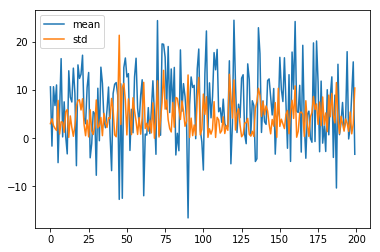

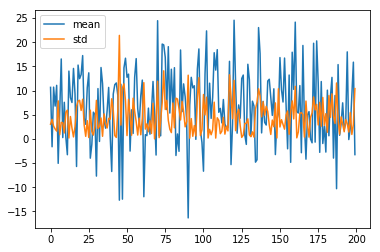

In [11]:
def show_mean_std(df):
    means = []
    stds = []
    for f in features:
        feat = df[f]
        means.append(np.mean(feat))
        stds.append(np.std(feat))

    fig = plt.figure()
    plt.plot(means, label="mean")
    plt.plot(stds, label="std")
    plt.legend()
    plt.show()

show_mean_std(train_df)
show_mean_std(test_df)

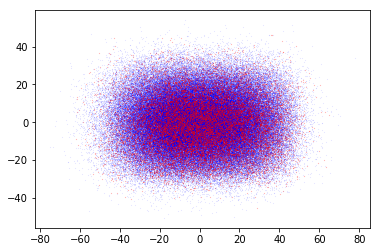

In [67]:
A = np.array(train_df[features])
B = np.array(test_df[features])
pca = PCA(n_components=2)

A_ = pca.fit_transform(A)
B_ = pca.transform(B)

label0, label1 = [], []
for data, label in zip(A_, target):
    if label == 1:
        label1.append(data)
    else:
        label0.append(data)
label0 = np.asarray(label0)
label1 = np.asarray(label1)

plt.scatter(label0[:, 0], label0[:, 1], color="blue", label="label0", s=0.001)
plt.scatter(label1[:, 0], label1[:, 1], color="red", label="label1", s=0.01)
plt.show()